DataFrameにレースのラップタイムの情報を追加し、図示するコード

その他、DataFrameの1つの特徴量(主に離散変数)に対してレース結果を分類して表にするコード等、分析のための図示を行なっている

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Hiragino Sans'
import seaborn as sns
pd.options.display.max_info_columns = 200
pd.set_option('display.max_columns', 50)
import numpy as np
import re
import os
import collections
import tqdm
from tqdm.notebook import trange
from func_timeout import func_timeout, FunctionTimedOut
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import warnings
warnings.simplefilter('ignore')
import gc
from datetime import datetime
from datetime import date

/Users/haradahiroto/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Lap_plot:
    
    def lap_scr(self, race_url):
        tab = pd.read_html(race_url)[5]
        laps = tab.loc[tab[0]=="ラップ", 1][0].split("-")
        laps = [float(l.strip()) for l in laps]
        paces = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[0].split("-")
        tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
        paces = [float(p.strip()) for p in paces]
        ten = float(tl.split("-")[0].replace("(", ""))
        last = float(tl.split("-")[1].replace(")", ""))
        browser = webdriver.Chrome()
        browser.get(race_url)
        ag_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(12)")
        agaris = [float(td.text) for td in ag_tds]
        kati_ag = agaris[0]
        saisoku_ag = sorted(agaris)[0]
        dict = {"lap": laps, "paces": paces, "ten_3f": ten, "last_3f": last,
                "winning": kati_ag, "fastest": saisoku_ag}
        return dict

    def lap_scr_df(self, df, url_col="race_url", rest_100=False):
        browser = webdriver.Chrome()
        df["lap"] = 0
        df["race_ten3f"] = 0
        df["race_last3f"] = 0
        df["race_mids"] = 0
        df["horse_last3f"] = 0
        df["horse_mids"] = 0
        df["position"] = 0
        df["last_corner"] = 0
        df["avg_last3f"] = 0
        df["avg_mid"] = 0
        for race_url in df[url_col].unique().tolist():
            tab = pd.read_html(race_url)[5]
            df.loc[df[url_col]==race_url, "lap"] = tab.loc[tab[0]=="ラップ", 1][0]
            tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
            ten = float(tl.split("-")[0].replace("(", ""))
            last = float(tl.split("-")[1].replace(")", ""))
            browser.get(race_url)
            #contents_liquid > table > tbody > tr.txt_c.even > th:nth-child(1)
            r_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(1)")
            rs = [td.text for td in r_tds]
            ag_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(12)") 
            time_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(8)")
            pos_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(11)")
            mozi = [str(r).isdigit() for r in rs]
            if False in mozi:
                ag_tds = ag_tds[:mozi.index(False)]
                time_tds = time_tds[:mozi.index(False)]
                pos_tds = pos_tds[:mozi.index(False)]
            agaris = [float(td.text) for td in ag_tds]
            times = [self.time_to_float(td.text) for td in time_tds]
            mids = times[0] - last
            middles = [t-a for a, t in zip(agaris, times)]
            positions = [td.text for td in pos_tds]
            last_corner = [int(p.split("-")[-1]) for p in positions]
            avg_last3fs = [a/3 for a in agaris]
            midf = int(np.round(df[df[url_col]==race_url].iloc[0].dist / 200)) - 3
            if rest_100:
                midf += 0.5
            avg_mids = [m/midf for m in middles]
            df.loc[df[url_col]==race_url, "race_ten3f"] = ten
            df.loc[df[url_col]==race_url, "race_last3f"] = last
            df.loc[df[url_col]==race_url, "race_mids"] = mids
            df.loc[df[url_col]==race_url, "horse_last3f"] = agaris
            df.loc[df[url_col]==race_url, "horse_mids"] = middles
            df.loc[df[url_col]==race_url, "position"] = positions
            df.loc[df[url_col]==race_url, "last_corner"] = last_corner
            df.loc[df[url_col]==race_url, "avg_last3f"] = avg_last3fs
            df.loc[df[url_col]==race_url, "avg_mid"] = avg_mids
        return df

    def pre_lap_scr_df(self, df, col, col_name="", koba=False, koba_horse_name="None"): #そのレースのラップもurlが格納されているcolを与えれば馬ごとにスクレイピングできるようにしている
        browser = webdriver.Chrome()
        col_list = ["lap", "race_ten3f", "race_last3f", "race_mids", "horse_last3f", "horse_mids",
                    "position", "last_corner", "avg_last3f", "avg_mid"]
        for x in col_list:
            df[col_name+x] = 0
        for i, race_url in enumerate(tqdm.tqdm(df[col].tolist())):
            if race_url=="None":
                for x in col_list:
                    df.loc[i, col_name+x] = np.nan
            else:
                try:
                    tab = pd.read_html(race_url)[5]
                except IndexError:
                    for x in col_list:
                        df.loc[i, col_name+x] = np.nan
                else:
                    df.loc[i, col_name+"lap"] = tab.loc[tab[0]=="ラップ", 1][0]
                    tl = tab.loc[tab[0]=="ペース", 1][1].split("\xa0")[1]
                    race_ten = float(tl.split("-")[0].replace("(", ""))
                    race_last = float(tl.split("-")[1].replace(")", ""))
                    browser.get(race_url)
                    if koba:
                        horse_name = koba_horse_name
                    else:
                        horse_name = df.loc[i, "horse_name"]
                    name_tds = browser.find_elements(By.CSS_SELECTOR, "td:nth-child(4)")
                    names = [name.text for name in name_tds]
                    ind = names.index(horse_name)+2
                    race_time = self.time_to_float(browser.find_element(By.CSS_SELECTOR, "td:nth-child(8)").text)
                    race_mids = race_time - race_last
                    df.loc[i, col_name+"race_ten3f"] = race_ten
                    df.loc[i, col_name+"race_last3f"] = race_last
                    df.loc[i, col_name+"race_mids"] = race_mids
                    try:
                        horse_last3f = float(browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(12)".format(ind)).text)
                    except ValueError:
                        horse_last3f = np.nan
                        horse_times = np.nan
                        horse_mids = np.nan
                        position = np.nan
                        last_corner = np.nan
                        avg_last3f = np.nan
                        avg_mid = np.nan 
                        df.loc[i, col_name+"horse_last3f"] = horse_last3f
                        df.loc[i, col_name+"horse_mids"] = horse_mids
                        df.loc[i, col_name+"position"] = position
                        df.loc[i, col_name+"last_corner"] = last_corner
                        df.loc[i, col_name+"avg_last3f"] = avg_last3f
                        df.loc[i, col_name+"avg_mid"] = avg_mid
                    else:
                        horse_time = self.time_to_float(browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(8)".format(ind)).text)
                        horse_mids = horse_time - horse_last3f
                        position = browser.find_element(By.CSS_SELECTOR, "tr:nth-child({}) > td:nth-child(11)".format(ind)).text
                        last_corner = int(position.split("-")[-1])
                        avg_last3f = horse_last3f / 3
                        midf = len(tab.loc[tab[0]=="ラップ", 1][0].split("-")) - 3
                        avg_mid = horse_mids / midf
                        df.loc[i, col_name+"horse_last3f"] = horse_last3f
                        df.loc[i, col_name+"horse_mids"] = horse_mids
                        df.loc[i, col_name+"position"] = position
                        df.loc[i, col_name+"last_corner"] = last_corner
                        df.loc[i, col_name+"avg_last3f"] = avg_last3f
                        df.loc[i, col_name+"avg_mid"] = avg_mid
        return df

    def result_scr(self, race_url, corner=True): #200で割り切れない距離の道中タイムに不備あり
        tabs = pd.read_html(race_url)
        tab = tabs[0]
        lap_tab = tabs[5]
        laps = [float(l) for l in lap_tab.iloc[1].tolist()]
        race_ten = laps[0]+laps[1]+laps[2]
        race_last3f = laps[-1]+laps[-2]+laps[-3]
        str_laps = ""
        for l in laps:
            str_laps += str(l)+"-"
        str_laps = str_laps[:-1]
        tab["lap"] = str_laps
        tab["race_ten"] = race_ten
        tab["race"] = 0
        if corner:
            tab["last_corner"] = tab['コーナー 通過順'].apply(lambda x: float(x[0]))
        tab["avg_last3f"] = tab["後3F"].apply(lambda x: float(x)/3)
        tab["avg_mid"] = tab.apply(lambda d: (self.time_to_float(d["タイム"]) - float(d["後3F"])) / (len(laps)-3), axis=1)
        tab = tab.rename(columns={"馬名":"horse_name"})
        return tab

    def lap_plot(self, laps, race_name, place_dist="京都24", rest_100=False, lap_split=True):
        plt.rcParams['font.family'] = 'Hiragino Sans'
        hanshin_16_gai = {
            "course_x": [0, 190, 290, 390, 1010, 1410, 1560, 1600],
            "course_y": [0, 0, -0.15, 0.2, 0.1, -1.8, 0, 0],
            "xticks": ["0", "200", "400", "(C)600", "(C)800", "(C)1000", "1200", "1400", "1600(473m)"],
            "yticks": [-2,0,8]
        }
        nakayama_25 = {
            "course_x": [0, 485, 600, 670, 770, 870, 1070, 1150, 1210, 1350, 1550, 1690, 2130, 2270, 2310, 2410, 2500],
            "course_y": [-2.1, -2.05, -3.0, -2.8, -0.3, -0.1, 2.3, 2.2, 2.0, 1.5, -1.8, -2.1, -2.05, -3.0, -2.8, -0.3, -0.1],
            "xticks": ["0", "(C)100", "(C)300", "(C)500", "700", "900", "(C)1100", "(C)1300", "1500", "1700", "(C)1900",
                      "(C)2100", "2300", "2500(293m)"],
            "yticks": [-4,0,16]
        }
        nakayama_20 = {
            "course_x": [0, 100, 170, 270, 370, 570, 650, 710, 850, 1050, 1190, 1630, 1770, 1810, 1910, 2000],
            "course_y": [-2.5, -3.0, -2.8, -0.3, -0.1, 2.3, 2.2, 2.0, 1.5, -1.8, -2.1, -2.05, -3.0, -2.8, -0.3, -0.1],
            "xticks": ["0", "200", "400", "(C)600", "(C)800", "1000", "1200", "(C)1400", "(C)1600", "1800", "2000(310m)"],
            "yticks": [-4,0,16]
        }
        nakayama_16 = {
            "course_x": [0, 80, 170, 350, 620, 910, 1180, 1310, 1360, 1410, 1510, 1600],
            "course_y": [2.4, 2.4, 2.05, 2, -1, -2, -1.9, -2.2, -2.5, -2.25, -0.3, -0.1],
            "xticks": ["0(C)", "200(C)", "400", "600", "800(C)", "1000(C)", "1200(C)", "1400", "1600(310m)"],
            "yticks": [-4,0,16]
        }
        kyoto_24 = {
            "course_x": [1000, 1220, 1310, 1580, 1720, 2150, 2400],
            "course_y": [0, 0, 2.1, 4, 0.5, -0.2, 0],
            "xticks": ["0", "200", "400", "600", "800", "1000", "1200", "1400", "1600(C)", "1800(C)", "2000(C)", "2200", "2400(404m)"],
            "yticks": [-2, 0, 16]
        }
        course_dist = {"阪神16外": hanshin_16_gai, "中山25": nakayama_25, "中山20": nakayama_20,
                       "中山16":nakayama_16, "京都24": kyoto_24}
        course = course_dist[place_dist]
        if lap_split:
            laps = laps.split("-")
            laps = [float(l.strip()) for l in laps]
        fs = [(n+1)*200 for n in range(len(laps))]
        if rest_100:
            fs = [f-100 for f in fs]
        fig, ax = plt.subplots(figsize=(10,4))
        ax2 = ax.twinx()
        sns.lineplot(x=fs, y=laps, marker="o", markersize=7, ax=ax)
        ax.grid(axis="y", alpha=0.7)
        ax.set_title(race_name)
        ax.set_xlabel("距離[m]")
        ax.set_ylabel("タイム[秒]")
        ax.set_xticks([0]+fs, course["xticks"])
        sns.lineplot(x=course["course_x"], y=course["course_y"], color="gray", alpha=0.1, ax=ax2)
        ax2.fill_between(course["course_x"], course["course_y"], [course["yticks"][0]]*len(course["course_x"]), color="gray", alpha=0.1)
        ax2.set_yticks(course["yticks"])
        for i, value in enumerate(laps):
            ax.text(fs[i], laps[i], np.round(value,1), size=10)
        plt.show()

    def lap_plot_personal(self, df, past=True):
        plt.rcParams['font.family'] = 'Hiragino Sans'
        for code in df.race.unique().tolist():
            race_df = df[df.race==code]
            fig, ax = plt.subplots(1,1,figsize=(20,8),tight_layout=True)
            if past:
                fig.suptitle(f"{race_df.iloc[0].year}-{race_df.iloc[0].month}-{race_df.iloc[0].day} {race_df.iloc[0].place} {race_df.iloc[0].race_rank} {race_df.iloc[0].GD}{race_df.iloc[0].dist}")
            horse_position = [f"{h[:5]}({p})" for h,p in zip(race_df.horse_name.tolist(), race_df.last_corner.tolist())]
            sns.lineplot(x=horse_position, y=race_df.avg_last3f.tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=horse_position, y=race_df.avg_mid.tolist(), marker="v", markersize=10, label="道中平均", ax=ax)
            ax.grid(axis="y", alpha=0.7)
            ax.set_title("個別ラップ")
            ax.set_xlabel("馬名(4角位置)")
            ax.set_ylabel("タイム[秒]")
            for i, value in enumerate(race_df.avg_last3f.tolist()):
                ax.text(horse_position[i], value, np.round(value,1), size=10)
            for i, value in enumerate(race_df.avg_mid.tolist()):
                ax.text(horse_position[i], value, np.round(value,1), size=10)
            plt.show()

    def lap_plot_win(self, df, title="勝馬比較"):
        win_df = df[df.result==1]
        fig, ax= plt.subplots(figsize=(20,8))
        horse_position = [f"{h[:5]}({p})" for h,p in zip(win_df.horse_name.tolist(), win_df.last_corner.tolist())]
        sns.lineplot(x=horse_position, y=win_df.avg_last3f.tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax)
        sns.lineplot(x=horse_position, y=win_df.avg_mid.tolist(), marker="v", markersize=10, label="道中平均", ax=ax)
        ax.grid(axis="y", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("馬名(4角位置)")
        ax.set_ylabel("タイム[秒]")
        for i, value in enumerate(win_df.avg_last3f.tolist()):
            ax.text(horse_position[i], value, np.round(value,1), size=10)
        for i, value in enumerate(win_df.avg_mid.tolist()):
            ax.text(horse_position[i], value, np.round(value,1), size=10)
        plt.rcParams['font.family'] = 'Hiragino Sans'
        plt.show()    

    def lap_plot_horse(self, df, past=True): #race_nameというcolを作る必要あり
        for i in range(3):
            df["pre{}_result".format(i+1)] = df["pre{}_result".format(i+1)].apply(lambda x: float(x[0]) if "降" in str(x) else x)
        for i in range(len(df)):
            race_name = df.iloc[i][["pre3_race_name", "pre2_race_name", "pre1_race_name"]].tolist()
            avg_last3f = df.iloc[i][["pre3_avg_last3f", "pre2_avg_last3f", "pre1_avg_last3f"]].tolist()
            avg_mid = df.iloc[i][["pre3_avg_mid", "pre2_avg_mid", "pre1_avg_mid"]].tolist()
            result = df.iloc[i][["pre3_result", "pre2_result", "pre1_result"]].tolist()
            last_corner = df.iloc[i][["pre3_last_corner", "pre2_last_corner", "pre1_last_corner"]].tolist()
            dist = df.iloc[i][["pre3_dist", "pre2_dist", "pre1_dist"]].tolist()
            place = df.iloc[i][["pre3_place", "pre2_place", "pre1_place"]].tolist()
            cond = df.iloc[i][["pre3_relative_cond", "pre2_relative_cond", "pre1_relative_cond"]].tolist()
            if past:
                race_name += [df.iloc[i]["race_name"]]
                avg_last3f += [df.iloc[i]["avg_last3f"]]
                avg_mid += [df.iloc[i]["avg_mid"]]
                result += [df.iloc[i]["result"]]
                last_corner += [df.iloc[i]["last_corner"]]
                dist += [df.iloc[i]["dist"]]
                place += [df.iloc[i]["place"]]
                cond += [df.iloc[i]["relative_cond"]]
            race_name = [x for x,y in zip(race_name, avg_mid) if not np.isnan(y)]
            if len(race_name) != len(set(race_name)):
                race_name = self.dup_dash(race_name)
            result = [float(x) for x,y in zip(result, avg_mid) if not np.isnan(y)]
            dist = [int(x) for x,y in zip(dist, avg_mid) if not np.isnan(y)]
            place = [x for x,y in zip(place, avg_mid) if not np.isnan(y)]
            cond = [int(x) for x,y in zip(cond, avg_mid) if not np.isnan(y)]
            last_corner = [x for x,y in zip(last_corner, avg_mid) if not np.isnan(y)]
            avg_last3f = [x for x in avg_last3f if not np.isnan(x)]
            avg_mid = [x for x in avg_mid if not np.isnan(x)]
            race_name = [f"{rn}\n{p}{d} ({c})" for rn,d,p,c in zip(race_name, dist, place, cond)]
            fig, ax = plt.subplots(figsize=(10,4))
            plt.rcParams['font.family'] = 'Hiragino Sans'
            ax2 = ax.twinx()
            sns.lineplot(x=race_name, y=avg_last3f, marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=race_name, y=avg_mid, marker="v", markersize=10, label="道中平均", ax=ax)
            sns.lineplot(x=race_name, y=result, marker="o", markersize=10, color="pink", label="着順", ax=ax2)
            sns.lineplot(x=race_name, y=last_corner, marker="s", markersize=10, color="gray", label="4角位置", ax=ax2)
            ax.set_title(df.iloc[i]["horse_name"])
            ax.set_xlabel("レース名")
            ax.set_ylabel("個別平均ラップ")
            ax.grid(axis="y", alpha=0.7)
            ax2.set_yticks(range(1,19))
            ax2.invert_yaxis()
            for i,value in enumerate(avg_last3f):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            for i,value in enumerate(avg_mid):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.get_legend().remove()
            ax2.legend(lines1+lines2, labels1+labels2)
            plt.show()

    def pre_lap_plot(self, df, pre_num=1): #同じ過去レースを走った馬のdfを与える
        plt.rcParams['font.family'] = 'Hiragino Sans'
        fig, ax= plt.subplots(1,2, figsize=(20,8), tight_layout=True)
        ax = ax.flatten()
        horse_position = [f"{h[:5]}({p})" for h,p in zip(df.horse_name.tolist(), df["pre{}_last_corner".format(pre_num)].tolist())]
        sns.lineplot(x=horse_position, y=df["pre{}_avg_last3f".format(pre_num)].tolist(), marker="^", markersize=10, label="ラスト3F平均", ax=ax[0])
        sns.lineplot(x=horse_position, y=df["pre{}_avg_mid".format(pre_num)].tolist(), marker="v", markersize=10, label="道中平均", ax=ax[0])
        ax[0].grid(axis="y", alpha=0.7)
        ax[0].set_title(f'{df.iloc[0]["pre{}_place".format(pre_num)]}:{df.iloc[0]["pre{}_race_name".format(pre_num)]}')
        ax[0].set_xlabel("馬名(4角位置)")
        ax[0].set_ylabel("タイム[秒]")
        for i, value in enumerate(df["pre{}_avg_last3f".format(pre_num)].tolist()):
            ax[0].text(horse_position[i], value, np.round(value,1), size=10)
        for i, value in enumerate(df["pre{}_avg_mid".format(pre_num)].tolist()):
            ax[0].text(horse_position[i], value, np.round(value,1), size=10)
        laps = df.iloc[0]["pre{}_lap".format(pre_num)].split("-")
        laps = [float(l.strip()) for l in laps]
        fs = [(n+1)*200 for n in range(len(laps))]
        sns.lineplot(x=fs, y=laps, marker="o", markersize=10, ax=ax[1])
        ax[1].grid(axis="y", alpha=0.7)
        ax[1].set_title("レースラップ")
        ax[1].set_xlabel("距離[m]")
        ax[1].set_ylabel("タイム[秒]")
        for i, value in enumerate(laps):
            ax[1].text(fs[i], laps[i], value, size=10)
        plt.show()

    def koba_plot(self, df, past=True):  #conditon = (tab.place=="中山")&(tab.dist>=1800)&(tab.dist<=22200) 随時変更
        for i, horse_url in enumerate(df["horse_url"].tolist()):
            html = requests.get(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            tabs = pd.read_html(horse_url)
            tab = tabs[3]
            if len(tab.columns)<20:
                tab = tabs[4]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab["url"] = urls
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]:].reset_index(drop=True)
            tab["place"] = tab["開催"].apply(self.to_place)
            tab["dist"] = tab["距離"].str[1:].astype(float)
            tab = tab[(tab.place=="中山")&(tab.dist>=1800)&(tab.dist<=22200)].reset_index(drop=True)
            tab = self.pre_lap_scr_df(tab, "url", koba=True, koba_horse_name=df.iloc[i]["horse_name"])
            tab = tab.rename(columns={"レース名": "race_name", "着 順": "result", "馬 場": "condition"})
            tab["result"] = tab["result"].apply(lambda x: float(x[0]) if "降" in str(x) else x)
            tab["last_corner"] = tab["position"].str[-1].astype(float)
            race_name = tab["race_name"].tolist()
            avg_last3f = tab["avg_last3f"].tolist()
            avg_mid = tab["avg_mid"].tolist()
            result = tab["result"].tolist()
            last_corner = tab["last_corner"].tolist()
            dist = tab["dist"].tolist()
            place = tab["place"].tolist()
            cond = tab["condition"].tolist()
            date = tab["日付"].tolist()
            race_name = [x for x,y in zip(race_name, avg_mid) if not np.isnan(y)]
            if len(race_name) != len(set(race_name)):
                race_name = self.dup_dash(race_name) 
            result = [float(x) for x,y in zip(result, avg_mid) if not np.isnan(y)]
            dist = [int(x) for x,y in zip(dist, avg_mid) if not np.isnan(y)]
            place = [x for x,y in zip(place, avg_mid) if not np.isnan(y)]
            cond = [x for x,y in zip(cond, avg_mid) if not np.isnan(y)]
            last_corner = [x for x,y in zip(last_corner, avg_mid) if not np.isnan(y)]
            date = [x for x,y in zip(date, avg_mid) if not np.isnan(y)]
            avg_last3f = [x for x in avg_last3f if not np.isnan(x)]
            avg_mid = [x for x in avg_mid if not np.isnan(x)]
            race_name = [f"{rn}\n{p}{d} ({c})\n{da}" for rn,d,p,c,da in zip(race_name, dist, place, cond, date)]
            fig, ax = plt.subplots(figsize=(10,4))
            plt.rcParams['font.family'] = 'Hiragino Sans'
            ax2 = ax.twinx()
            sns.lineplot(x=race_name, y=avg_last3f, marker="^", markersize=10, label="ラスト3F平均", ax=ax)
            sns.lineplot(x=race_name, y=avg_mid, marker="v", markersize=10, label="道中平均", ax=ax)
            sns.lineplot(x=race_name, y=result, marker="o", markersize=10, color="pink", label="着順", ax=ax2)
            sns.lineplot(x=race_name, y=last_corner, marker="s", markersize=10, color="gray", label="4角位置", ax=ax2)
            ax.set_title(df.iloc[i]["horse_name"]) 
            ax.set_xlabel("レース名")
            ax.set_ylabel("個別平均ラップ")
            ax.grid(axis="y", alpha=0.7)
            ax2.set_yticks(range(1,19))
            ax2.invert_yaxis()
            for i,value in enumerate(avg_last3f):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            for i,value in enumerate(avg_mid):
                ax.text(race_name[i], value, np.round(value,1), size=10)
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.get_legend().remove()
            ax2.legend(lines1+lines2, labels1+labels2)
            plt.show()
        
    def pre_race_url(self, df, past=True, pre_num=3):
        for i in range(pre_num):
            df["pre{}_race_url".format(i+1)] = 0
        for i, horse_url in enumerate(tqdm.tqdm(df.horse_url.tolist())):
            html = self.get_html(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            date_tds = tab_soup.select("td:nth-child(1)")
            dates = [d.text for d in date_tds]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab = pd.DataFrame({"日付": dates, "urls": urls})
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()  
            for j in range(pre_num):
                try:
                    df.loc[i, "pre{}_race_url".format(j+1)] = tab["urls"].iloc[j]
                except IndexError:
                    df.loc[i, "pre{}_race_url".format(j+1)] = "None"
        return df

    def pre_race_url_all(self, df, past=True):
        for i, horse_url in enumerate(df.horse_url.tolist()):
            html = self.get_html(horse_url)
            soup = BeautifulSoup(html.content, "html.parser")
            tab_soups = soup.select("table")
            tab_soup = tab_soups[3]
            if len(tab_soup.select("td"))<10:
                tab_soup = tab_soups[4]
            date_tds = tab_soup.select("td:nth-child(1)")
            dates = [d.text for d in date_tds]
            url_tds = tab_soup.select("td:nth-child(5)")
            urls = ["https://db.netkeiba.com"+u.find("a").get("href") for u in url_tds]
            tab = pd.DataFrame({"日付": dates, "urls": urls})
            if past:
                race_date = f'{df.loc[i, "year"]}/{df.loc[i, "month"]:0=2}/{df.loc[i, "day"]:0=2}'
                tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()  
        return tab["urls"].tolist()

    def change_avg_mid(self, df):
        for i in range(3):
            pre_dist = "pre{}_dist".format(i+1)
            pre_avg_mid = "pre{}_avg_mid".format(i+1)
            print(df[(df[pre_dist]%200!=0)&(df[pre_avg_mid].notnull())].index)
            df.loc[(df[pre_dist]%200!=0)&(df[pre_avg_mid].notnull()), pre_avg_mid] = df[pre_avg_mid]*(df[pre_dist]//200-3+1)/(df[pre_dist]//200-3+((df[pre_dist]%200)/200))
        return df

    def long_dist(self, d):
        race_date = f'{d["year"]}/{d["month"]:0=2}/{d["day"]:0=2}'
        tab = self.horse_table_check(d["horse_url"])
        tab = tab.iloc[tab[tab["日付"]==race_date].index[0]+1:].reset_index()
        tab["dist"] = tab["距離"].apply(lambda x: float(x[1:]))
        tab["rank"] = tab["着 順"].apply(lambda x: 100 if (x=="中")|(x=="除")|(x=="取")|(x=="失")|("降" in str(x)) else float(x))
        count = len(tab[tab["dist"]>=3000])
        result_count = len(tab[(tab["dist"]>=3000)&(tab["rank"]<=3)])
        return count, result_count

    def make_long_col(df, past=True):
        if past:
            df["long_dist"]= df.apply(long_dist, axis=1)
        else:
           df["long_dist"] = df.apply(predict_long_dist, axis=1)
        df["長距離経験数"] = df["long_dist"].apply(lambda x: x[0])
        df["長距離馬券内数"] = df["long_dist"].apply(lambda x: x[1])
        df["長距離経験"] = "あり"
        df.loc[df["長距離経験数"]==0, "長距離経験"] = "なし"
        df["長距離馬券内"] = "あり"
        df.loc[df["長距離馬券内数"]==0, "長距離馬券内"] = "なし"
        df["長距離複数経験"] = "なし"
        df.loc[df["長距離経験数"]>=2, "長距離複数経験"] = "あり"
        df["長距離複数馬券内"] = "なし"
        df.loc[df["長距離馬券内数"]>=2, "長距離複数馬券内"] = "あり"
        return df
                        
    def dup_dash(self, race_name):
        new_race_name = race_name.copy()
        for i in range(len(race_name)-1):
            if race_name[i] == race_name[i+1]:
                new_race_name[i+1] = new_race_name[i]+"'"
        return new_race_name

    def get_html(self, url):
        return requests.get(url)

    def time_to_float(self, time):
        try:
            m,s = time.split(":")
        except (AttributeError, ValueError):
            m = 0
            s = 0
        return float(m)*60 + float(s)
    
    def make_col_df(self, df, col):
        group = df.groupby(col, as_index=True)
        c_df = pd.DataFrame(group.apply(lambda d: len(d)), columns=["頭数"])
        c_df["1着"] = group.apply(lambda d: len(d[d.result==1]))
        c_df["2着"] = group.apply(lambda d: len(d[d.result==2]))
        c_df["3着"] = group.apply(lambda d: len(d[d.result==3]))
        c_df["着外"] = group.apply(lambda d: len(d[d.result>=4]))
        c_df["勝率"] = group.apply(lambda d: f'{(len(d[d.result==1]) / len(d)) * 100:.2f}%')
        c_df["複勝率"] = group.apply(lambda d: f'{(len(d[d.result<4]) / len(d)) * 100:.2f}%')
        c_df["オッズ平均"] = group.apply(lambda d: d.odds.mean())
        c_df["1着オッズ平均"] = group.apply(lambda d: d[d.result==1].odds.mean())
        c_df["馬券内オッズ平均"] = group.apply(lambda d: d[d.result<=3].odds.mean())
        return c_df
        
    def ten_df(self, df, past=True):
        group = df.groupby("year", as_index=True)
        c_df = pd.DataFrame(group.apply(lambda d: len(d)), columns=["頭数"])
        c_df["前走1角平均"] = group.apply(lambda d: d["pre1_position"].str[0].astype(float).mean())
        c_df["前走1角中央値"] = group.apply(lambda d: d["pre1_position"].str[0].astype(float).median())
        c_df["前走テン3F平均"] = group.apply(lambda d: d["pre1_race_ten3f"].mean())
        c_df["前走テン3F中央値"] = group.apply(lambda d: d["pre1_race_ten3f"].median())
        c_df["前走道中平均平均"] = group.apply(lambda d: d["pre1_avg_mid"].mean())
        c_df["前走道中平均中央値"] = group.apply(lambda d: d["pre1_avg_mid"].median())
        c_df["前走1500m以下"] = group.apply(lambda d: len(d[d["pre1_dist"]<=1500]))
        c_df["前走1600m"] = group.apply(lambda d: len(d[d["pre1_dist"]==1600]))
        c_df["前走1700m以上"] = group.apply(lambda d: len(d[d["pre1_dist"]>=1700]))
        if past:
            c_df["テン3F"] = group.apply(lambda d: d["race_ten3f"].mean())
            c_df["道中平均平均"] = group.apply(lambda d: d["avg_mid"].mean())
            c_df["道中平均中央値"] = group.apply(lambda d: d["avg_mid"].median())
            c_df["勝馬道中平均"] = group.apply(lambda d: d.iloc[0]["avg_mid"])
            c_df["ラスト3F平均平均"] = group.apply(lambda d: d["avg_last3f"].mean())
            c_df["馬場指数"] = group.apply(lambda d:d["relative_cond"].mean())
        return c_df

    def relative_time_plot(self, df):
        for i in range(3):
            df["pre{}_relative_time".format(i+1)] = df["pre{}_relative_time".format(i+1)].astype(float)
        df["ave_relative_time"] = df.apply(lambda d: np.mean([time for time in [d.pre1_relative_time, d.pre2_relative_time, d.pre3_relative_time] if not np.isnan(time)]), axis=1)
        df["max_relative_time"] = df.apply(lambda d: max([d.pre1_relative_time, d.pre2_relative_time, d.pre3_relative_time]), axis=1)
        fig, ax = plt.subplots(figsize=(15,15))
        sns.scatterplot(x=df.ave_relative_time, y=df.max_relative_time, ax=ax)
        for i, value in enumerate(df.horse_name):
            ax.text(df.ave_relative_time[i], df.max_relative_time[i], value)
        plt.show()


In [3]:
lp = Lap_plot()

In [4]:
df = pd.read_csv("/Users/haradahiroto/machine_learning/z_keiba/csv_folder/asahi.csv")
pdf = pd.read_csv("/Users/haradahiroto/machine_learning/z_keiba/predict_folder/asahi23.csv")

In [5]:
df = lp.lap_scr_df(df)
df = lp.pre_race_url(df)
for i in range(3):
    df = lp.pre_lap_scr_df(df, "pre{}_race_url".format(i+1), "pre{}_".format(i+1))
df = lp.change_avg_mid(df)
df["race_name"] =  "朝日杯FS"

100%|████████████████████████████████████████████████████████████████| 147/147 [05:02<00:00,  2.06s/it]

Index([], dtype='int64')
Index([0, 11, 23, 39, 102, 125], dtype='int64')
Index([4, 62, 74, 81, 84, 87, 99, 129], dtype='int64')


In [6]:
pdf["day"] = 17
pdf = pdf.drop([9, 15], axis=0).reset_index(drop=True)
pdf = lp.pre_race_url(pdf)
for i in range(3):
    pdf = lp.pre_lap_scr_df(pdf, "pre{}_race_url".format(i+1), "pre{}_".format(i+1))
pdf = lp.change_avg_mid(pdf)

100%|██████████████████████████████████████████████████████████████████| 17/17 [02:07<00:00,  7.52s/it]


Index([], dtype='int64')
Index([], dtype='int64')
Index([3], dtype='int64')


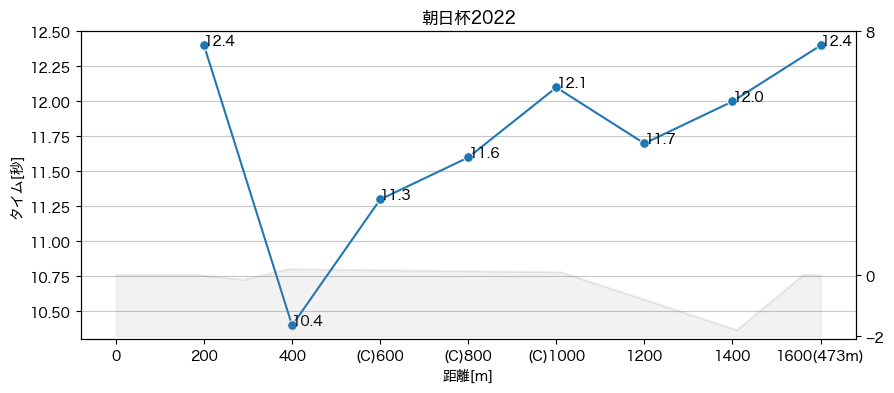

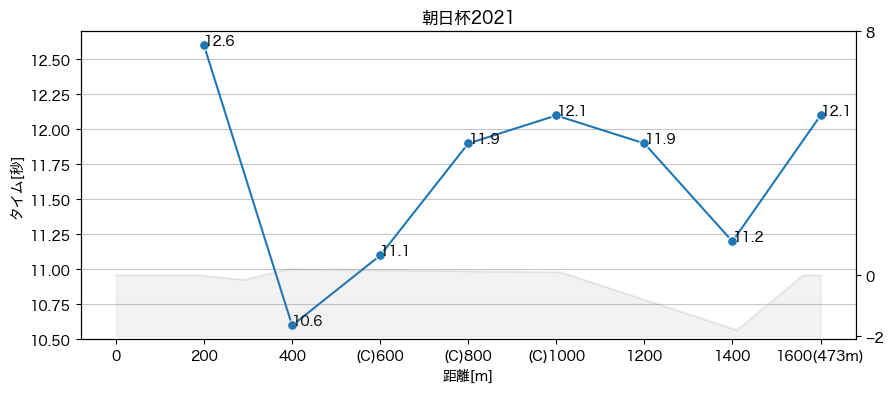

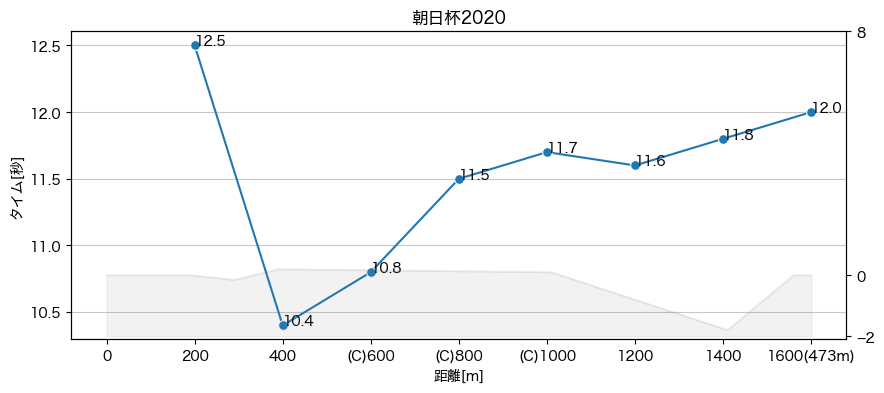

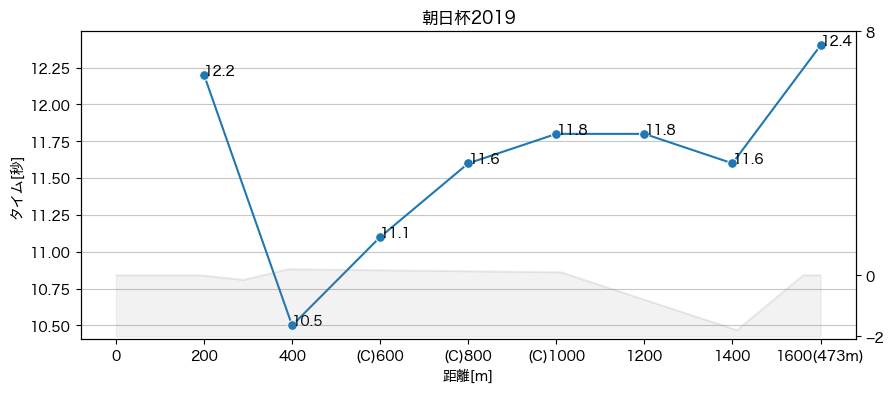

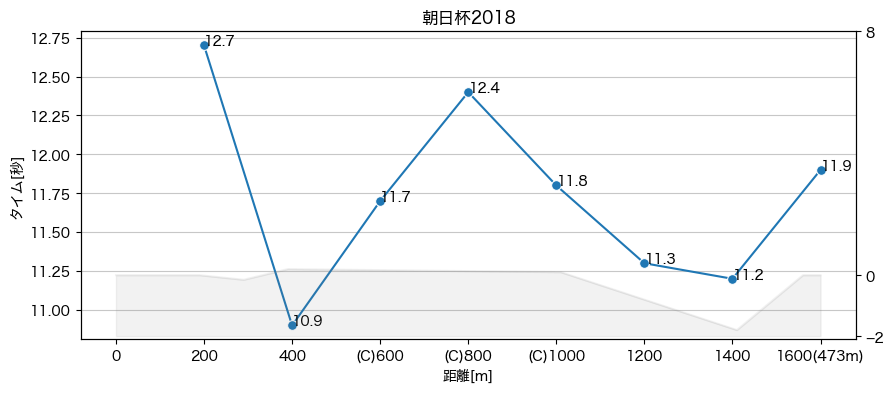

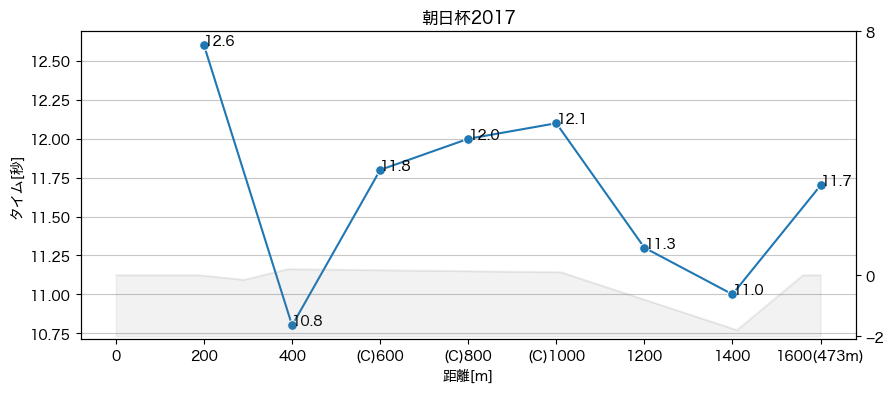

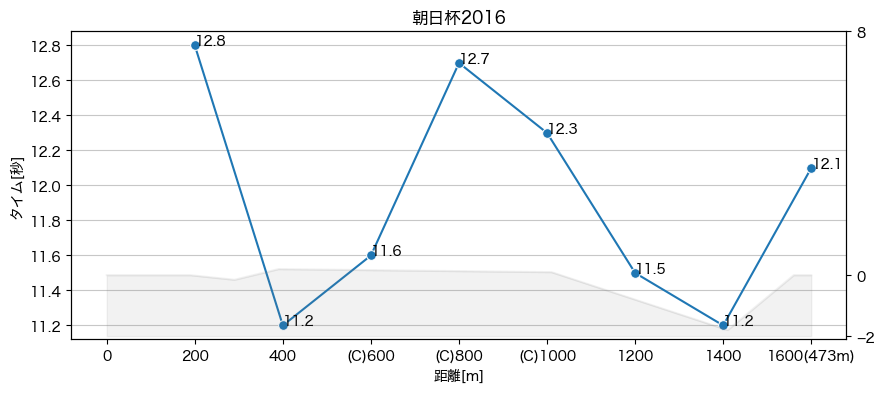

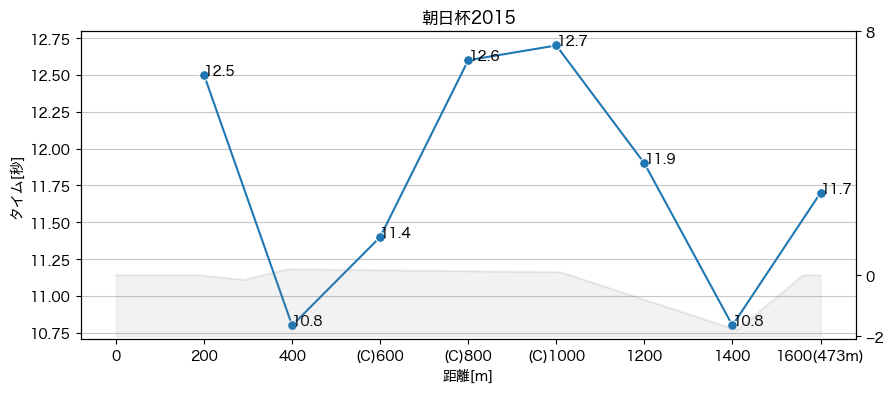

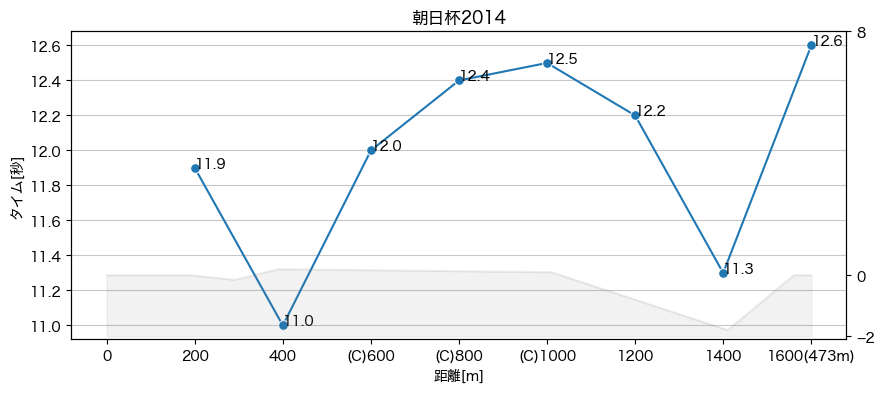

In [7]:
for lap, year in zip(df.lap.unique().tolist(), df.year.unique().tolist()):
    lp.lap_plot(lap, "朝日杯{}".format(year), place_dist="阪神16外")

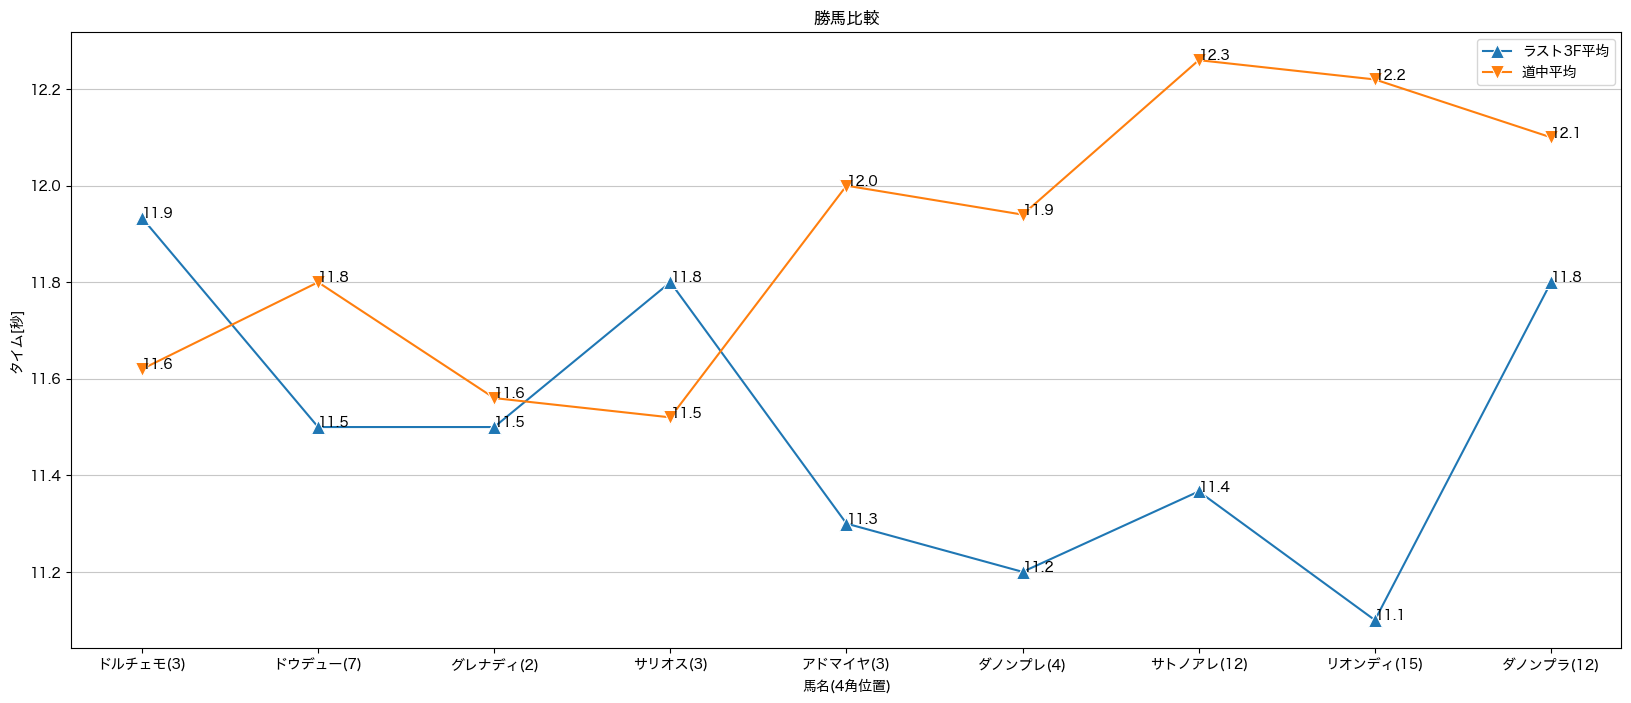

In [8]:
lp.lap_plot_win(df)

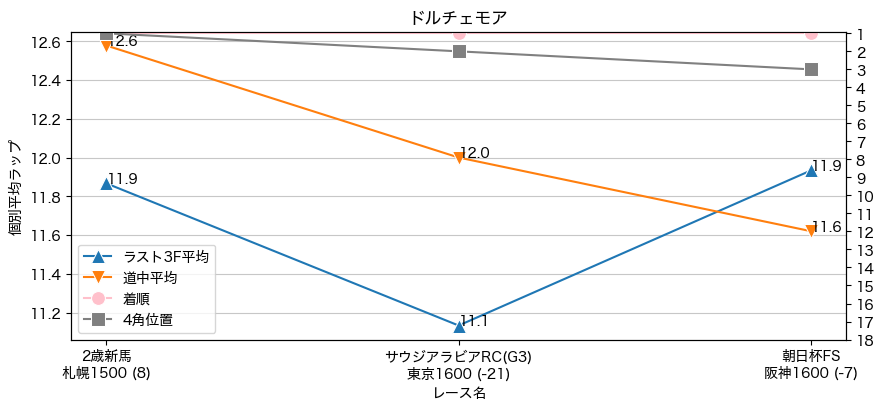

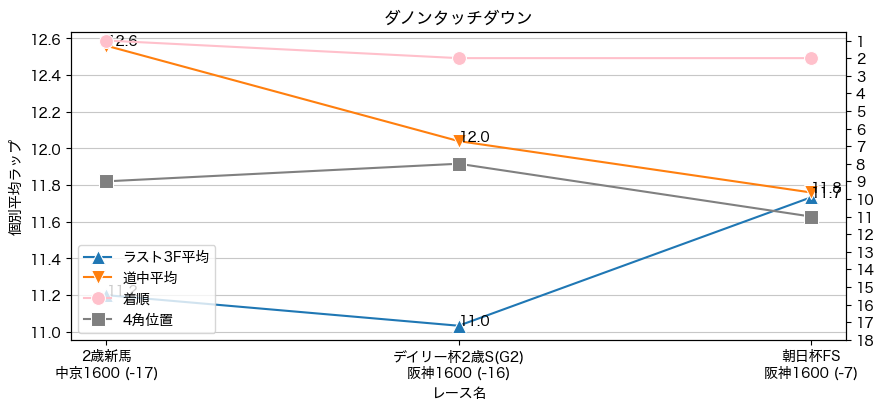

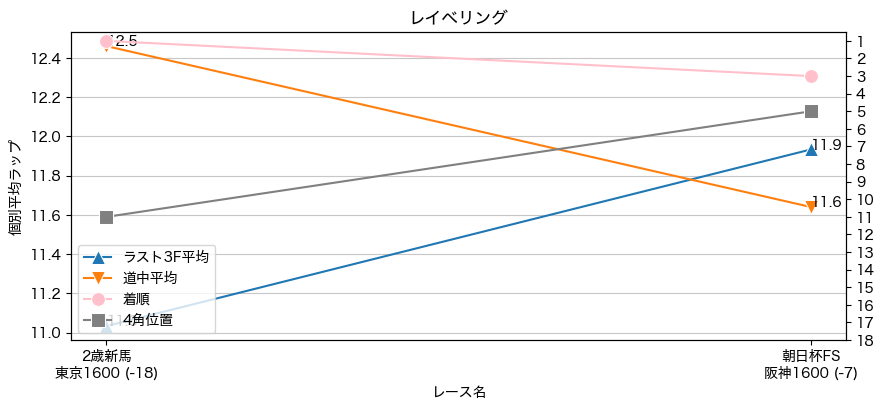

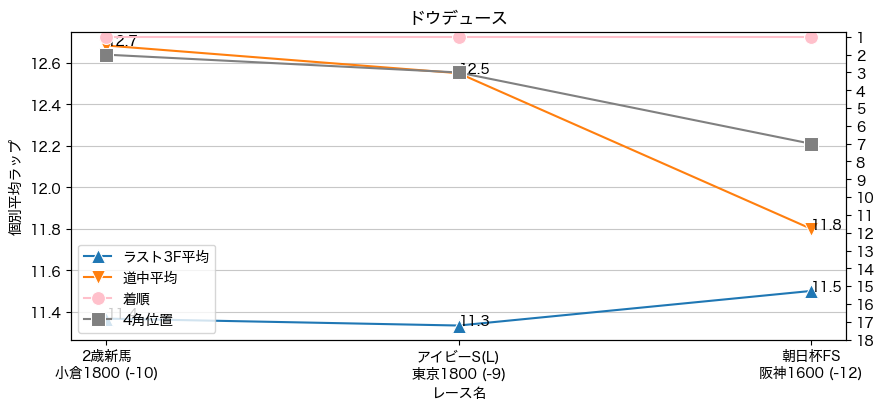

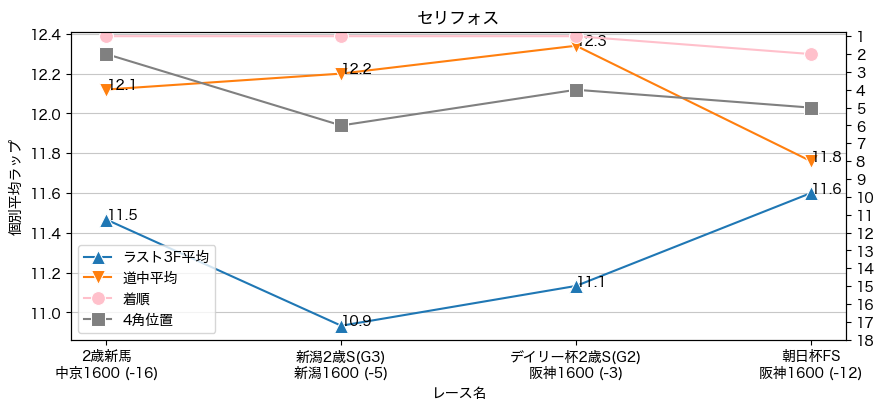

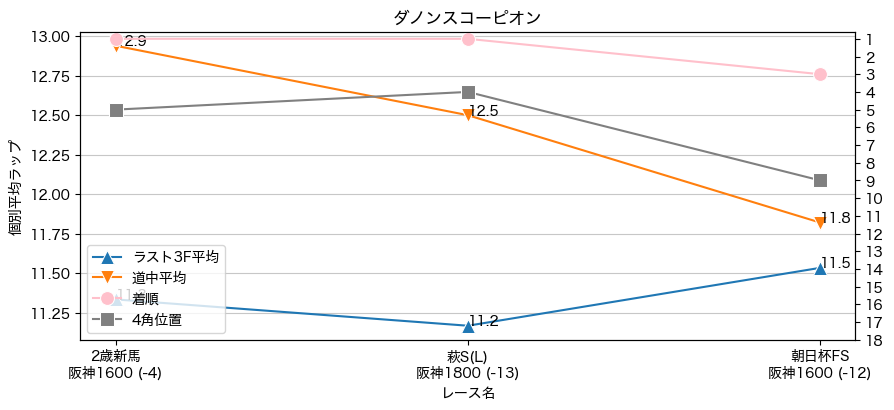

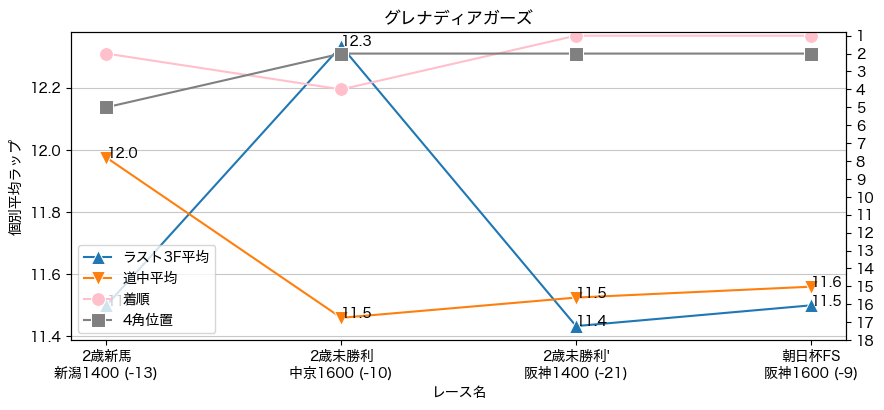

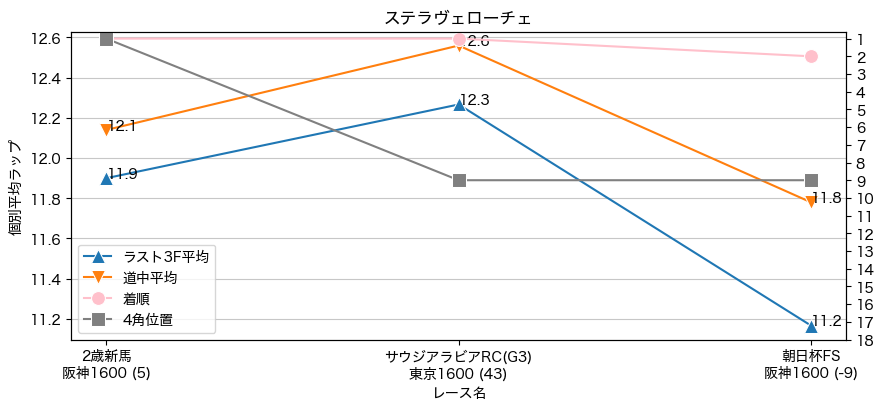

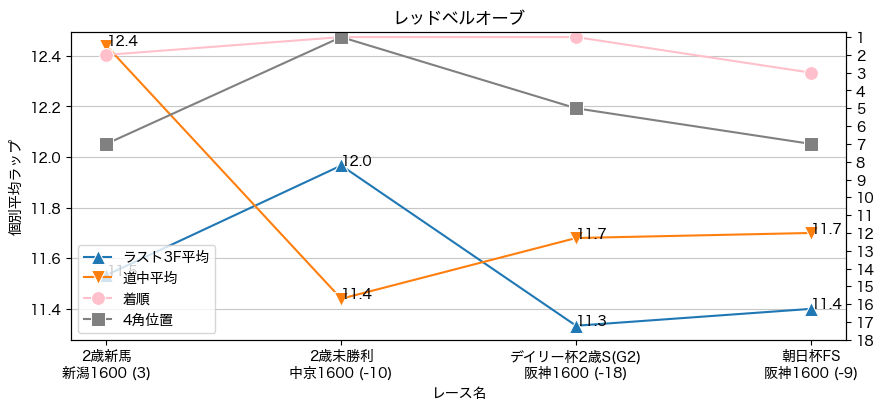

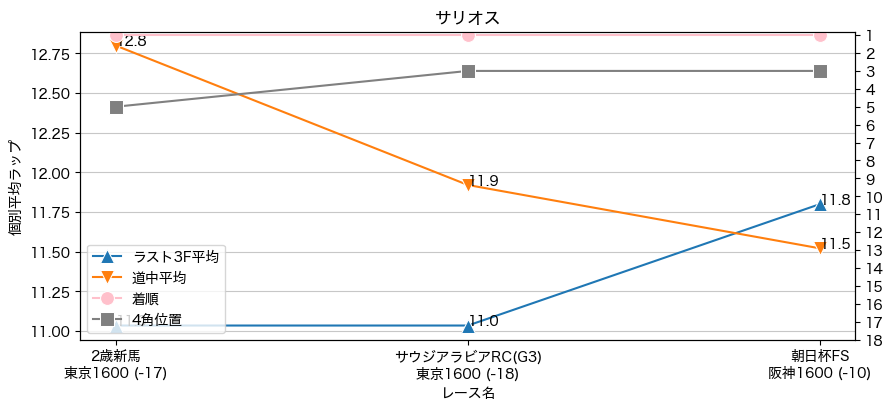

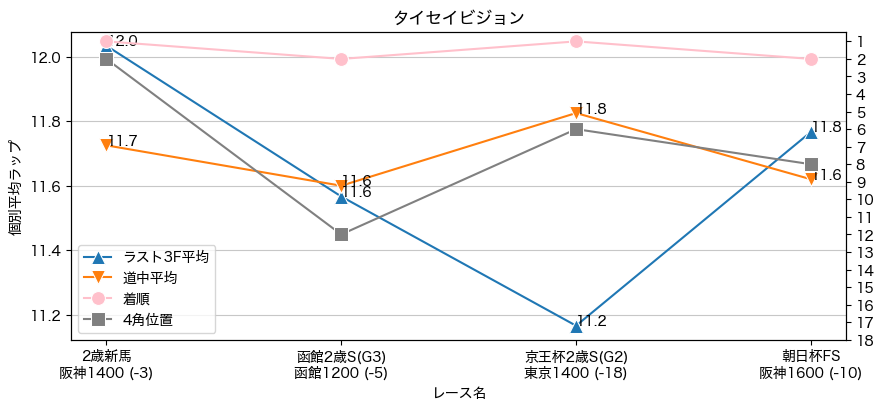

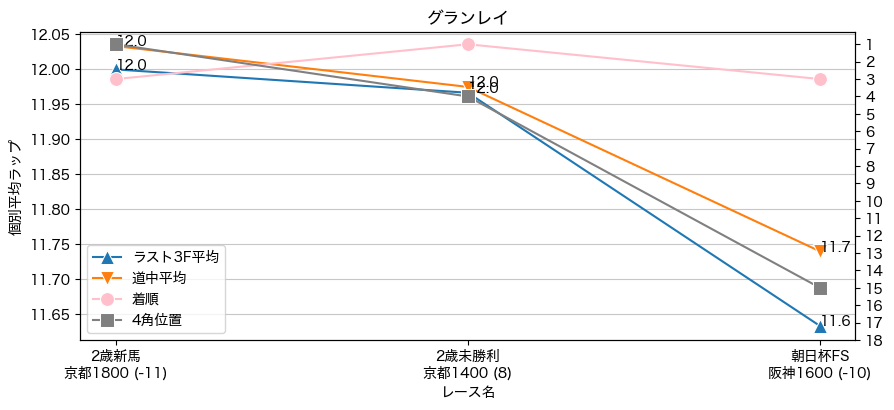

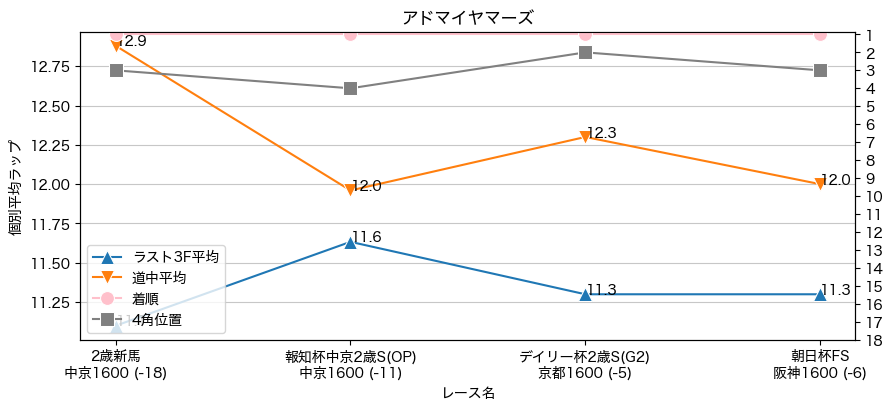

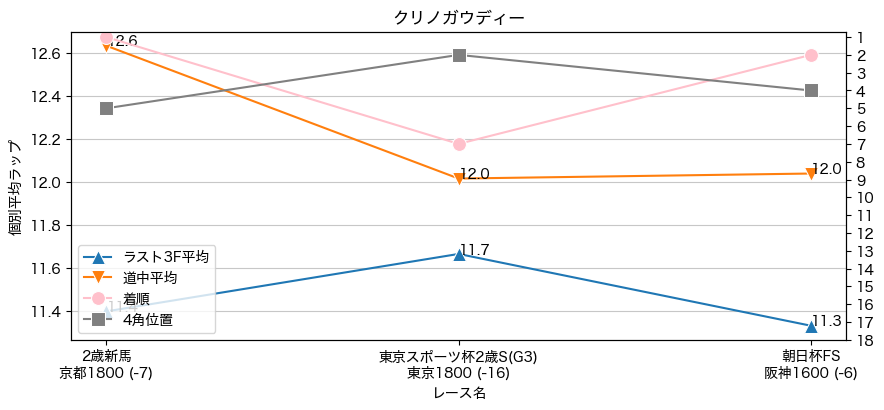

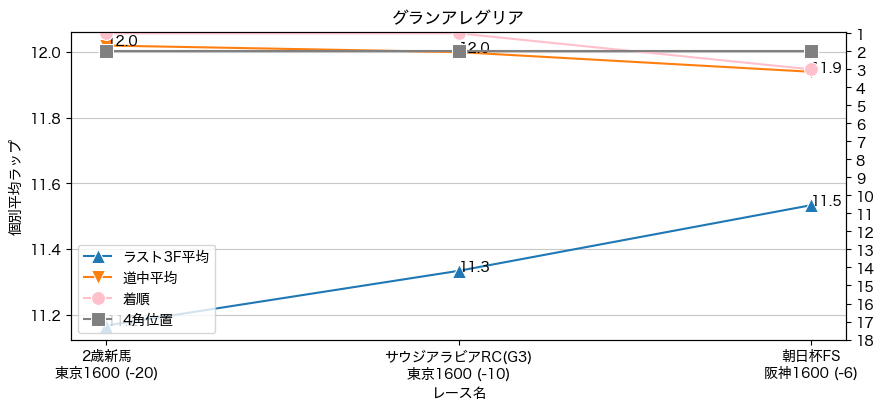

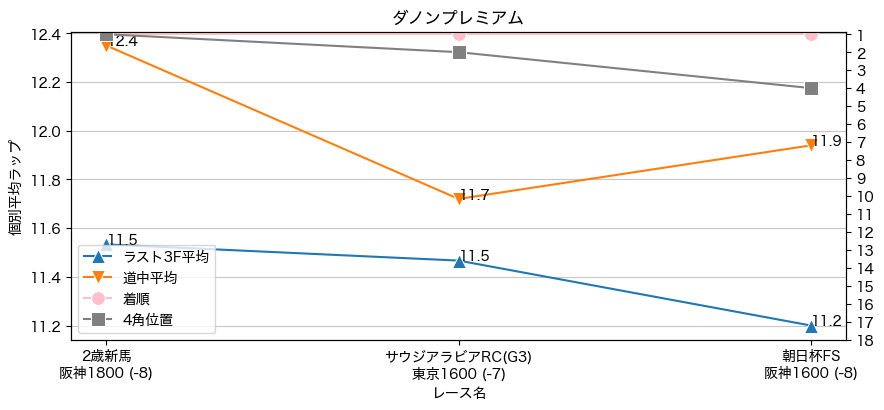

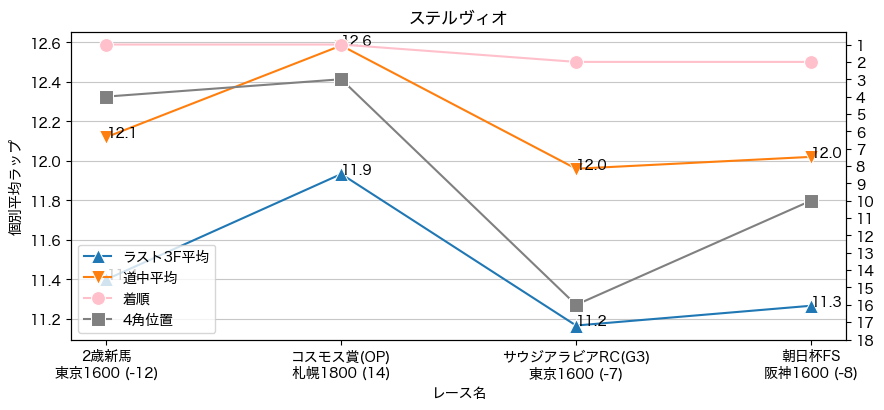

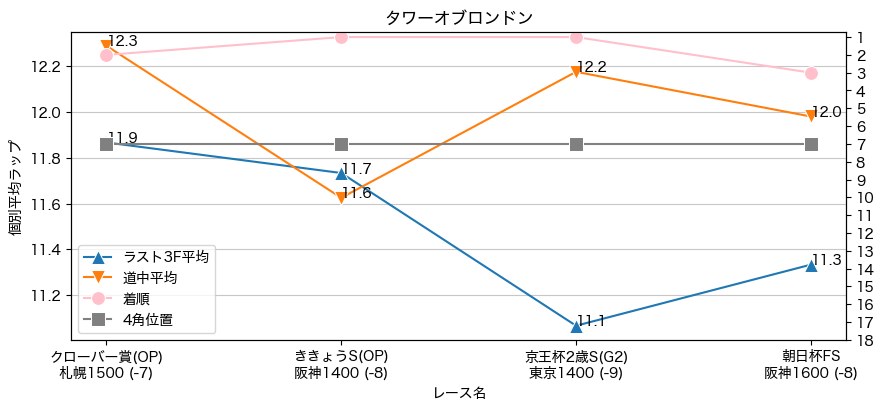

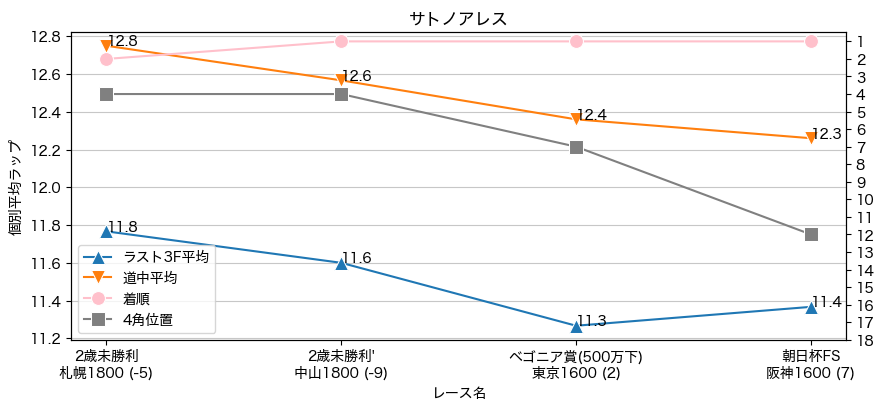

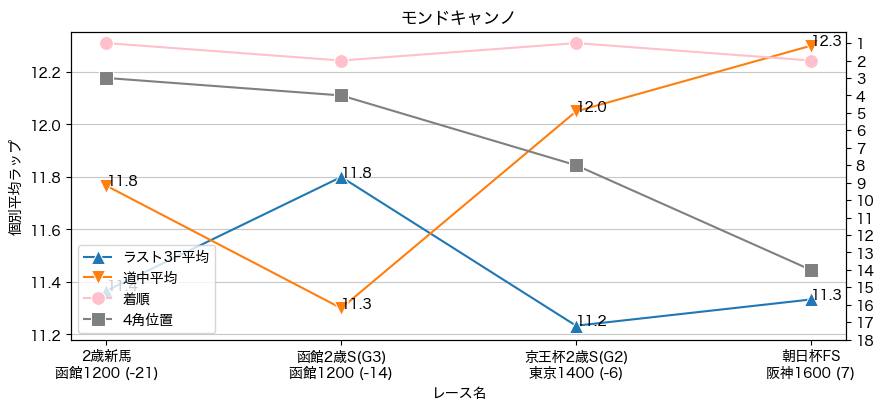

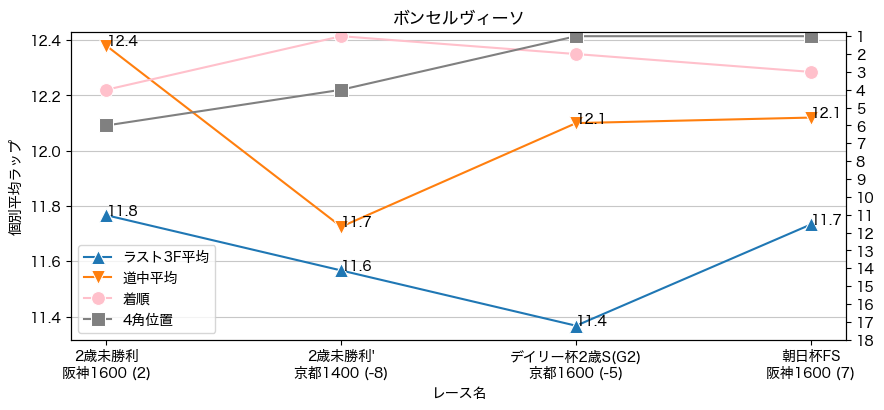

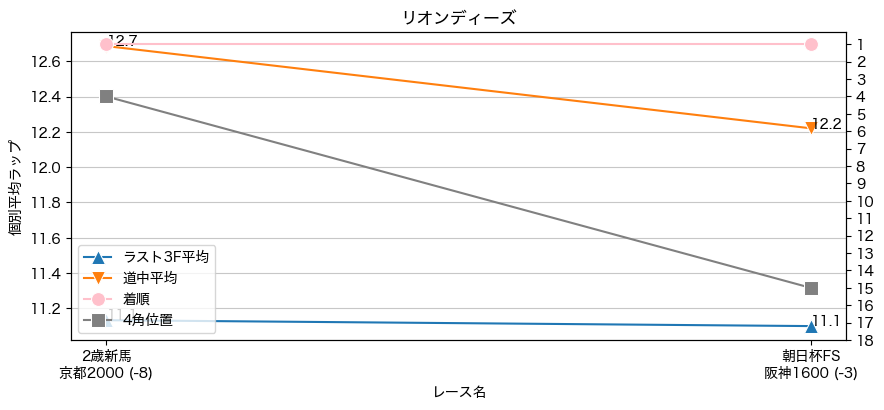

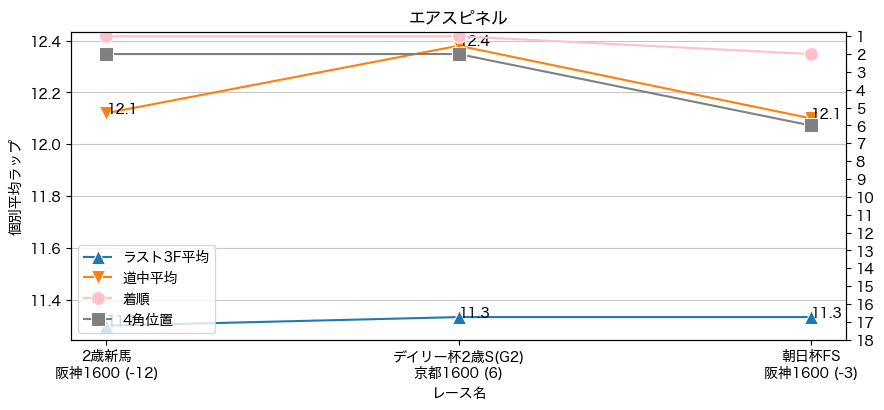

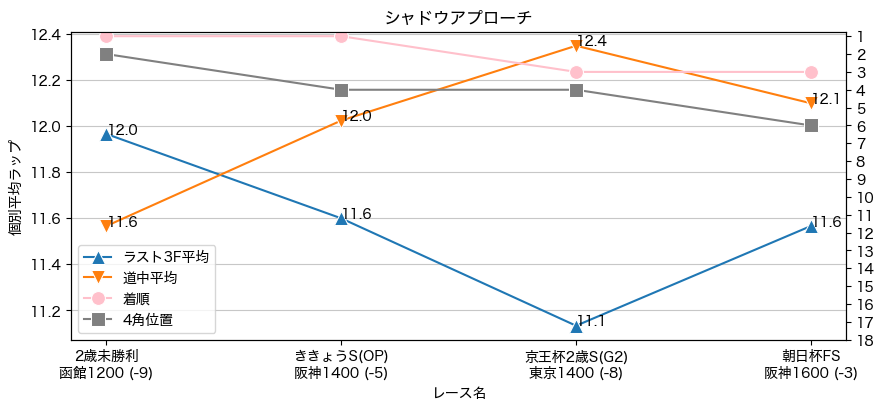

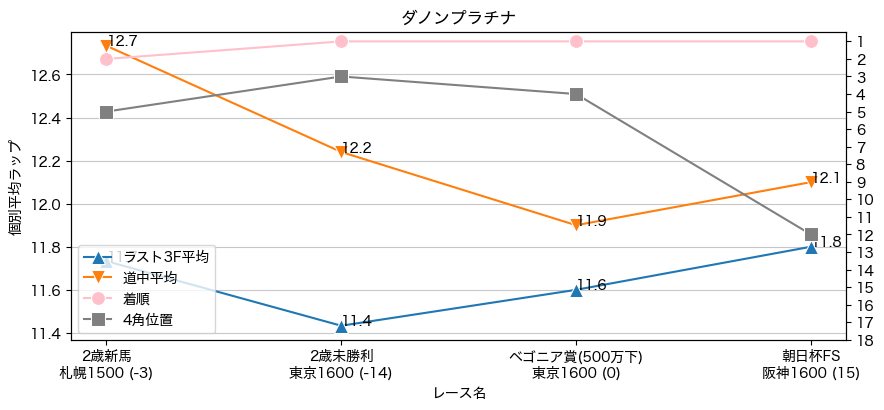

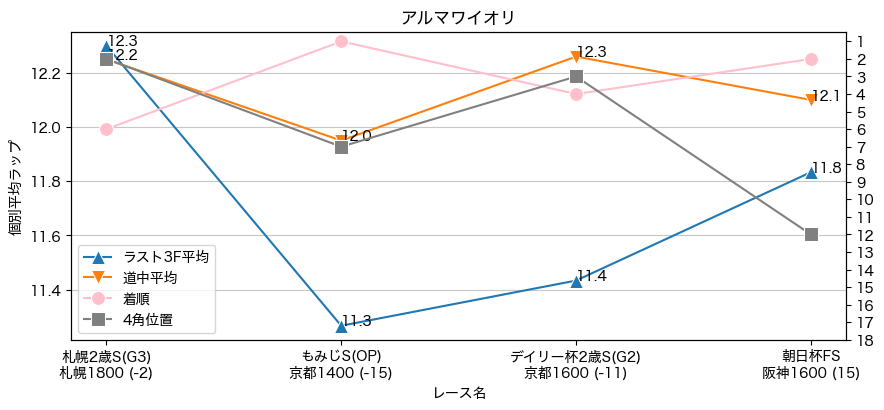

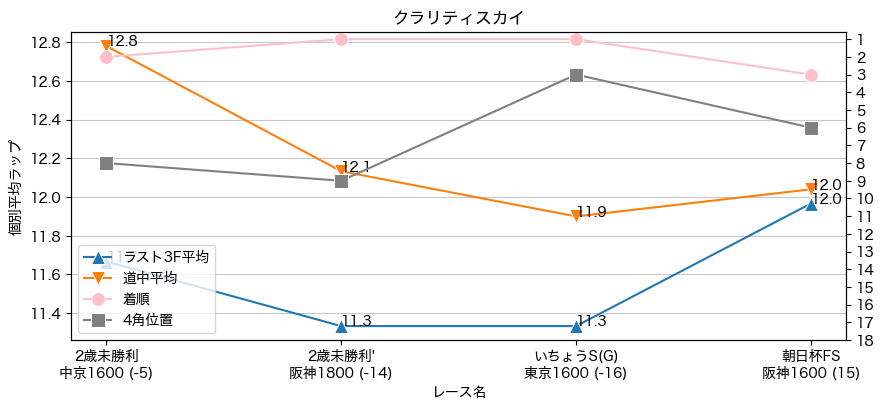

In [9]:
lp.lap_plot_horse(df[df.result<=3])

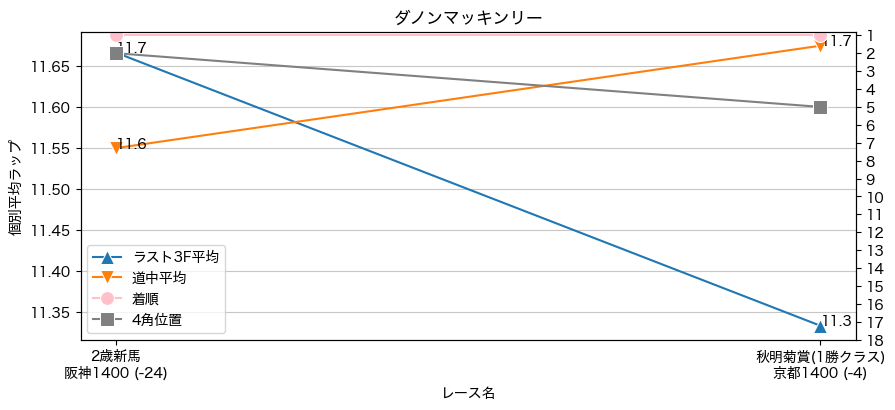

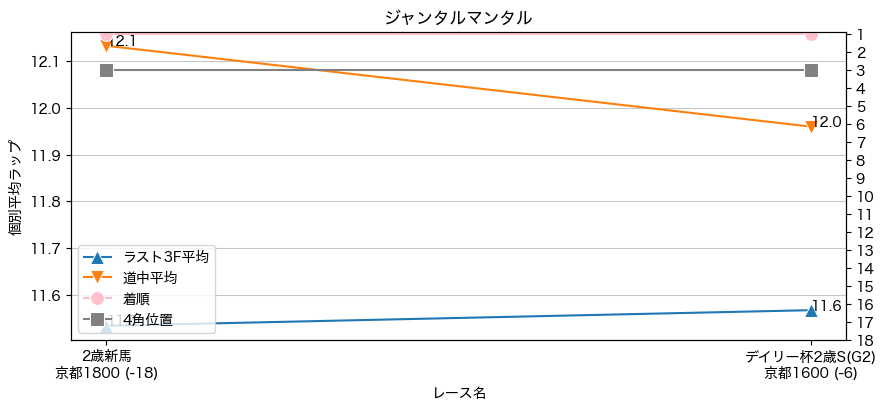

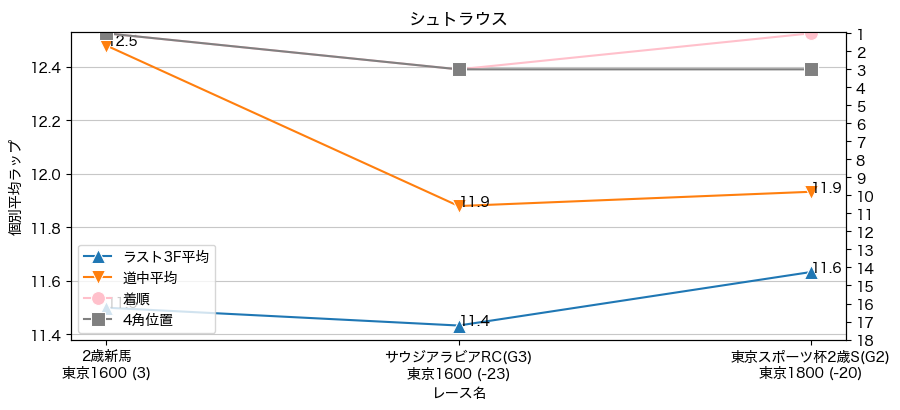

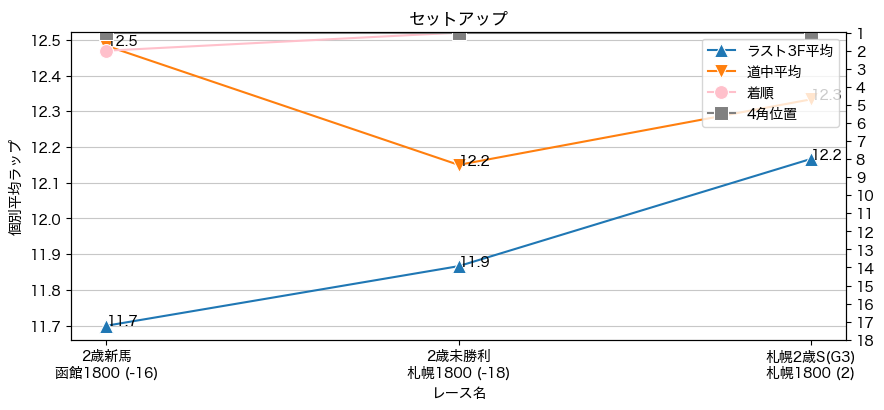

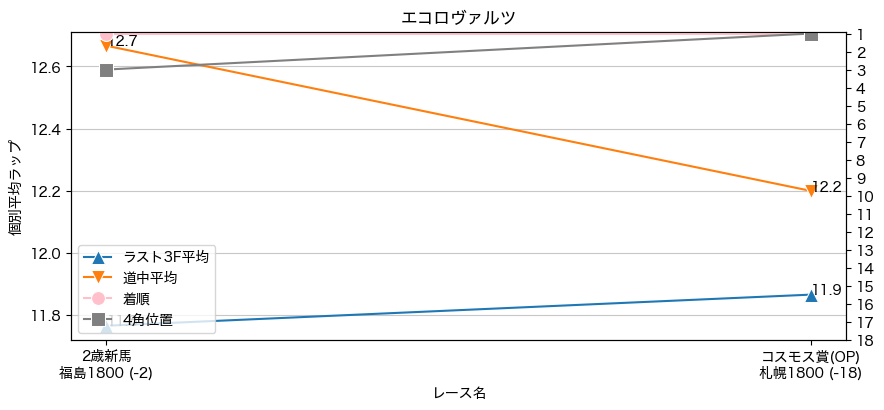

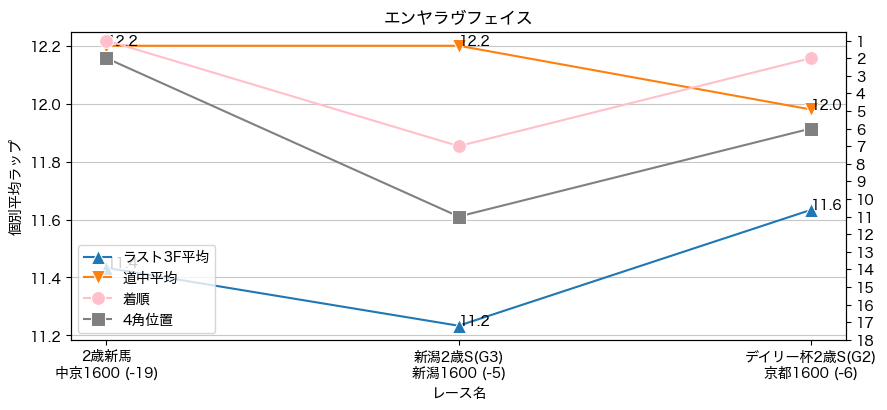

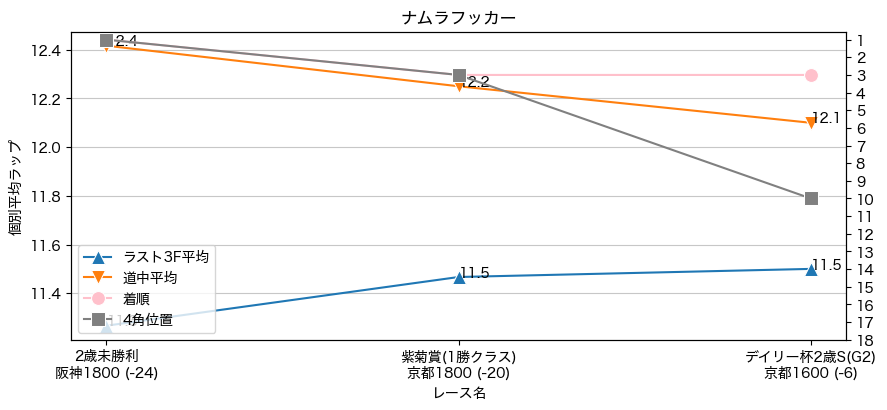

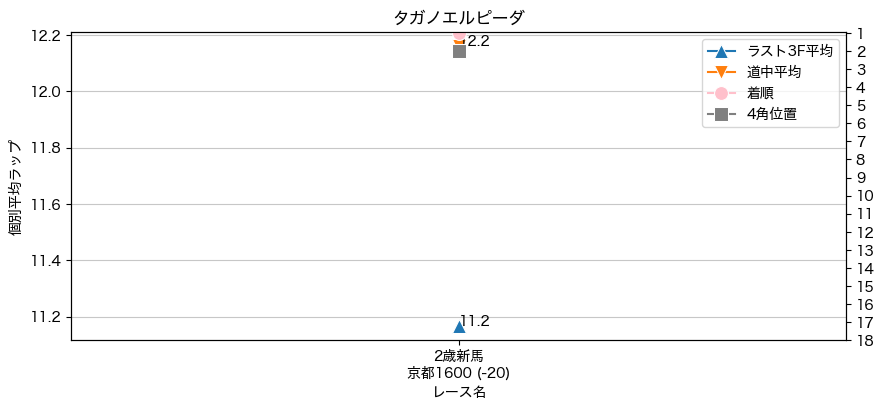

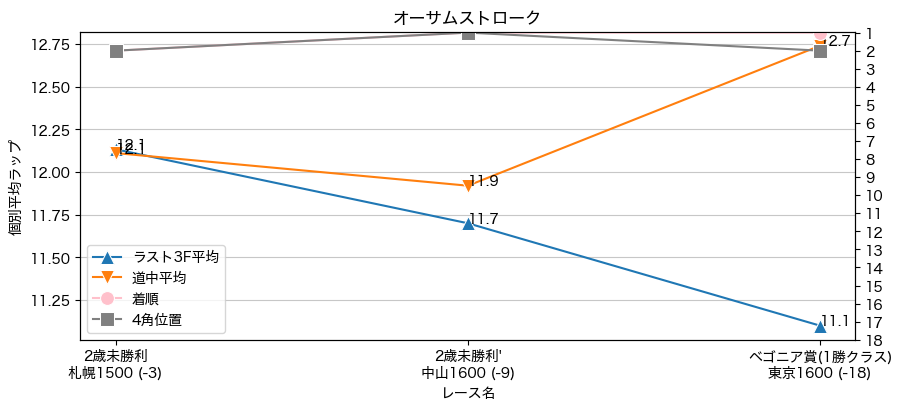

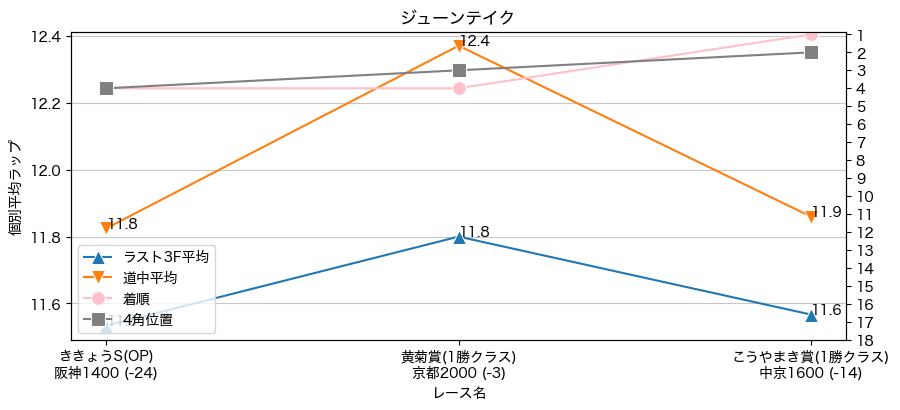

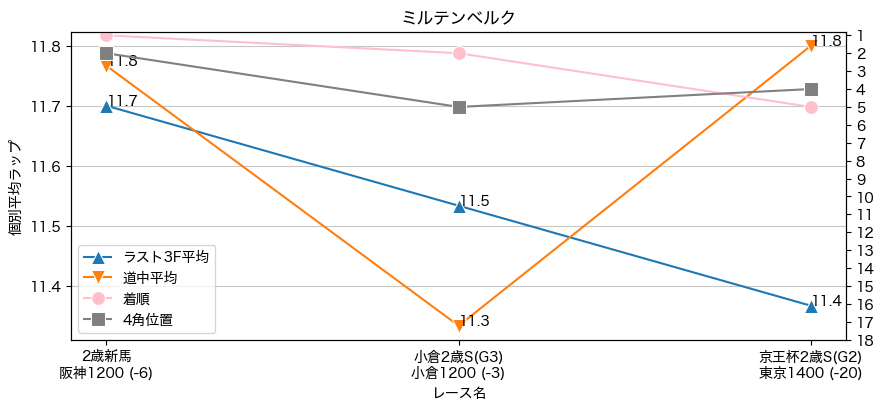

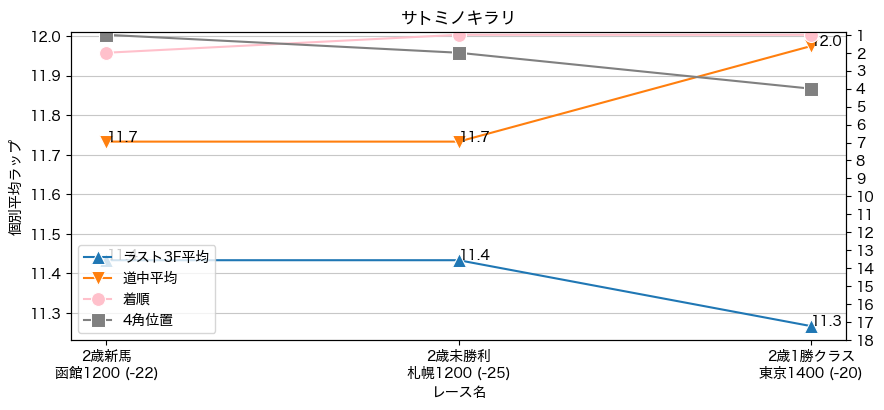

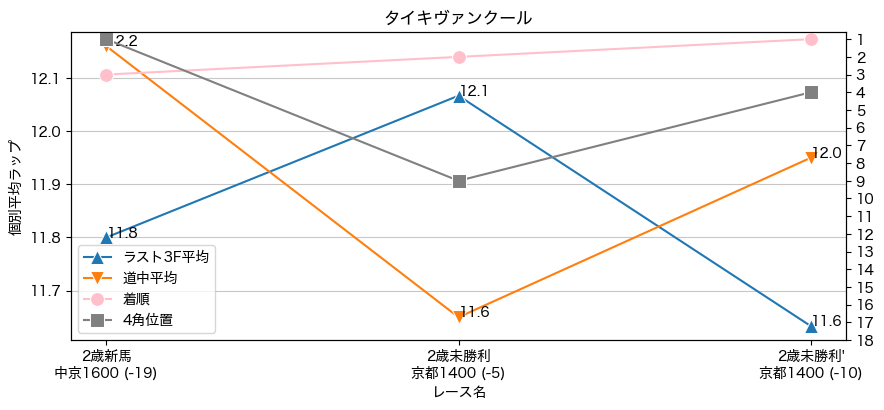

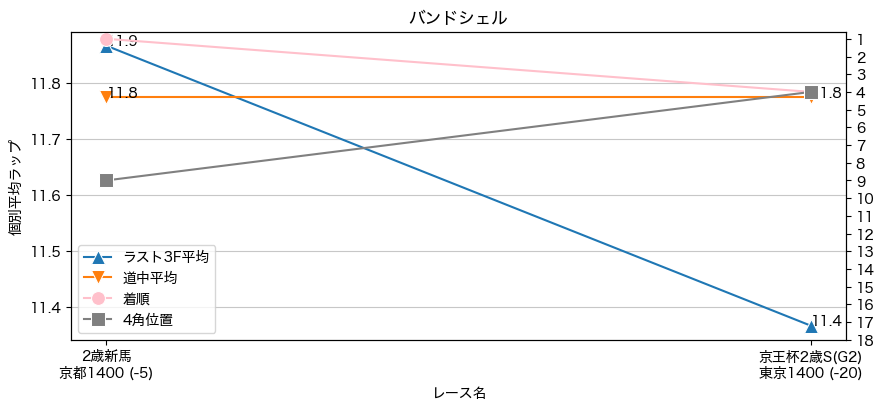

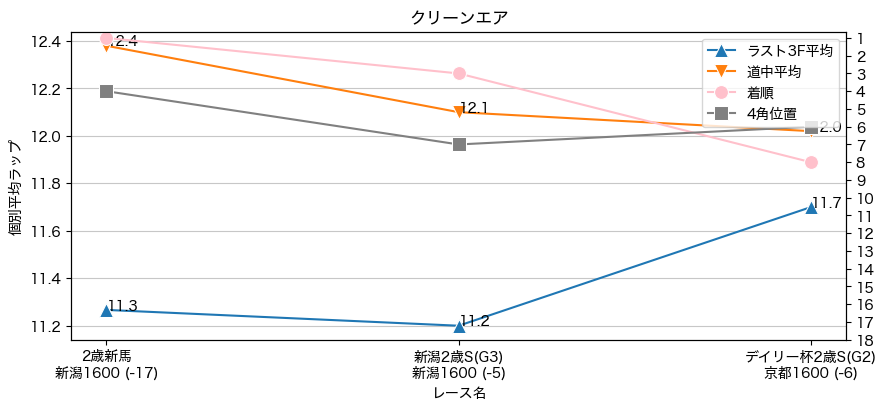

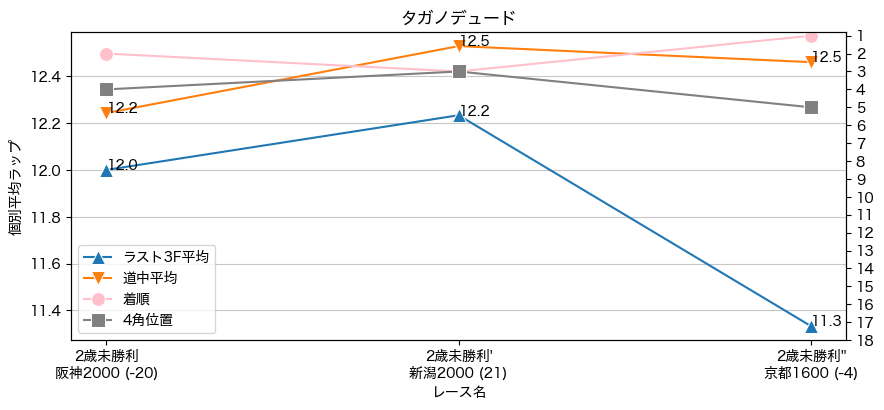

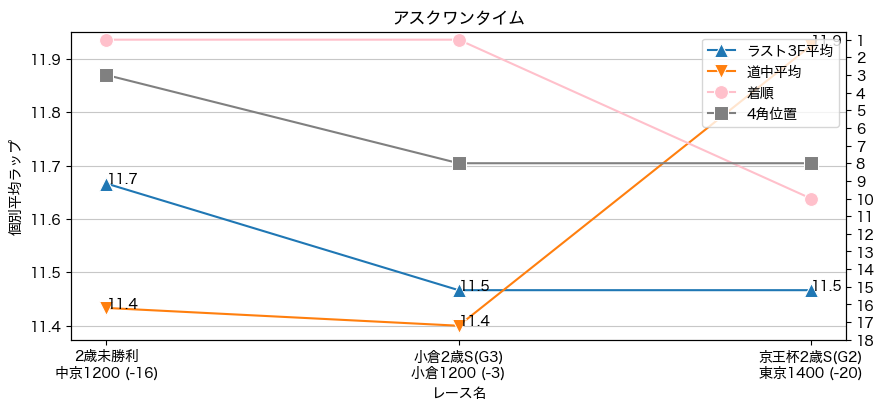

In [10]:
lp.lap_plot_horse(pdf.sort_values("popular"), past=False)

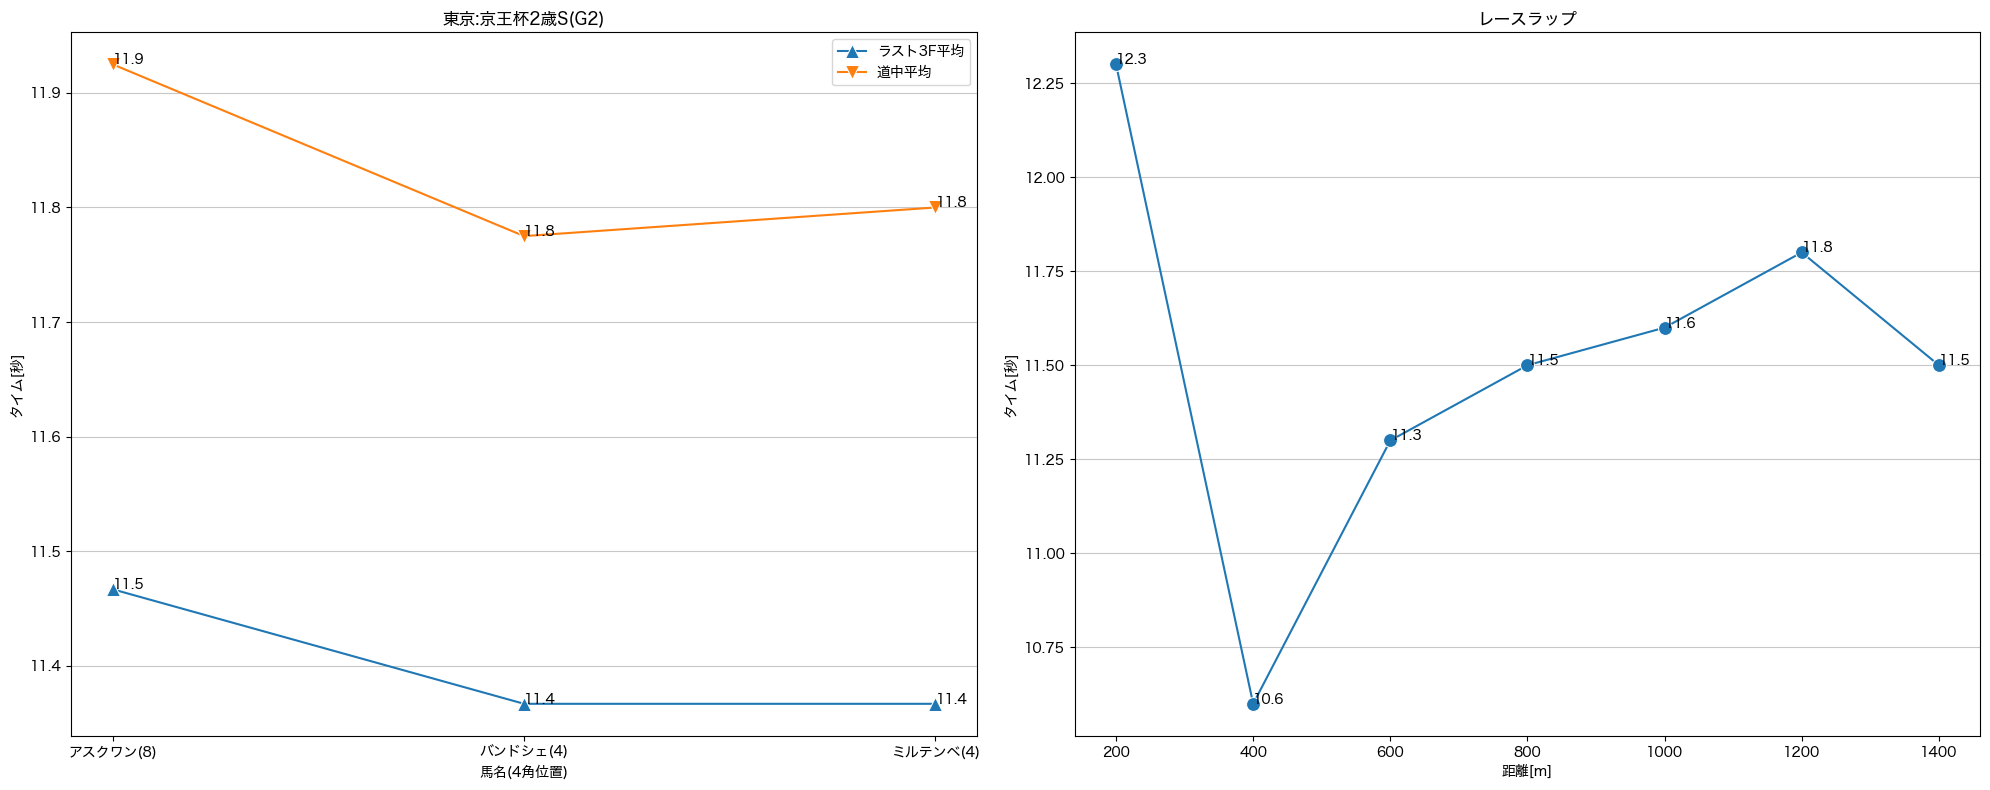

In [11]:
lp.pre_lap_plot(pdf[pdf.pre1_race_name=="京王杯2歳S(G2)"])

In [12]:
lp.make_col_df(df, "waku")

頭数  1着  2着  3着  着外      勝率     複勝率       オッズ平均  1着オッズ平均   馬券内オッズ平均
waku                                                                    
1     16   4   1   0  11  25.00%  31.25%   84.825000    6.875  20.980000
2     18   0   0   3  15   0.00%  16.67%  104.044444      NaN  26.033333
3     18   1   2   0  15   5.56%  16.67%   74.844444    2.000  23.033333
4     18   1   2   2  13   5.56%  27.78%   72.127778    4.600   5.540000
5     18   1   2   1  14   5.56%  22.22%  105.555556    7.800  64.550000
6     18   0   2   0  16   0.00%  11.11%   94.127778      NaN   2.550000
7     20   0   0   3  17   0.00%  15.00%  114.190000      NaN  34.466667
8     21   2   0   0  19   9.52%   9.52%  107.285714   10.050  10.050000

In [13]:
lp.make_col_df(df, "pre1_dist")

頭数  1着  2着  3着  着外      勝率     複勝率       オッズ平均    1着オッズ平均  \
pre1_dist                                                              
1200        5   0   0   0   5   0.00%   0.00%  247.040000        NaN   
1400       57   1   2   3  51   1.75%  10.53%  112.364912  17.500000   
1600       59   6   6   5  42  10.17%  28.81%   68.164407   5.133333   
1700        1   0   0   0   1   0.00%   0.00%  443.800000        NaN   
1800       20   1   1   1  17   5.00%  15.00%   82.940000   7.800000   
2000        5   1   0   0   4  20.00%  20.00%   48.460000   5.900000   

            馬券内オッズ平均  
pre1_dist             
1200             NaN  
1400       60.650000  
1600       11.876471  
1700             NaN  
1800       31.633333  
2000        5.900000

In [14]:
lp.ten_df(df)

頭数    前走1角平均  前走1角中央値   前走テン3F平均  前走テン3F中央値   前走道中平均平均  前走道中平均中央値  \
year                                                                      
2014  18  4.111111      4.0  35.250000       35.4  12.060833    12.0600   
2015  16  4.875000      5.0  35.993750       36.5  12.264628    12.3125   
2016  18  3.882353      3.0  35.858824       35.7  12.224986    12.1500   
2017  16  3.466667      3.0  35.426667       35.7  12.089905    12.1000   
2018  15  4.214286      3.0  36.721429       36.8  12.380833    12.4025   
2019  16  3.562500      3.0  35.275000       35.3  11.957500    12.0100   
2020  16  3.625000      3.0  35.206250       35.0  11.969122    11.9625   
2021  15  3.200000      2.0  35.573333       35.7  12.076333    12.1000   
2022  17  3.411765      2.0  35.188235       34.8  11.924020    11.9750   

      前走1500m以下  前走1600m  前走1700m以上  テン3F     道中平均平均  道中平均中央値  勝馬道中平均  \
year                                                                    
2014          6        8          4  34.9  12.074444    12.07   12.10   
2015          7        5          4  34.7  12.125000    12.13   12.22   
2016          8        6          4  35.6  12.240000    12.24   12.26   
2017          7        6          3  35.2  11.992500    12.00   11.94   
2018          6        5          4  35.3  12.160000    12.18   12.00   
2019          9        7          0  33.8  11.602500    11.61   11.52   
2020          5        9          2  33.7  11.723750    11.73   11.56   
2021          6        5          4  34.3  11.801333    11.80   11.80   
2022          8        8          1  34.1  11.716471    11.72   11.62   

      ラスト3F平均平均  馬場指数  
year                   
2014  12.298148  15.0  
2015  11.660417  -3.0  
2016  11.742593   7.0  
2017  11.547917  -8.0  
2018  11.506667  -6.0  
2019  12.166667 -10.0  
2020  11.560417  -9.0  
2021  11.868889 -12.0  
2022  12.052941  -7.0

In [15]:
lp.ten_df(pdf, past=False)

頭数    前走1角平均  前走1角中央値   前走テン3F平均  前走テン3F中央値   前走道中平均平均  前走道中平均中央値  \
year                                                                      
2023  17  3.882353      3.0  35.476471       35.0  12.049804     11.975   

      前走1500m以下  前走1600m  前走1700m以上  
year                                 
2023          6        8          3

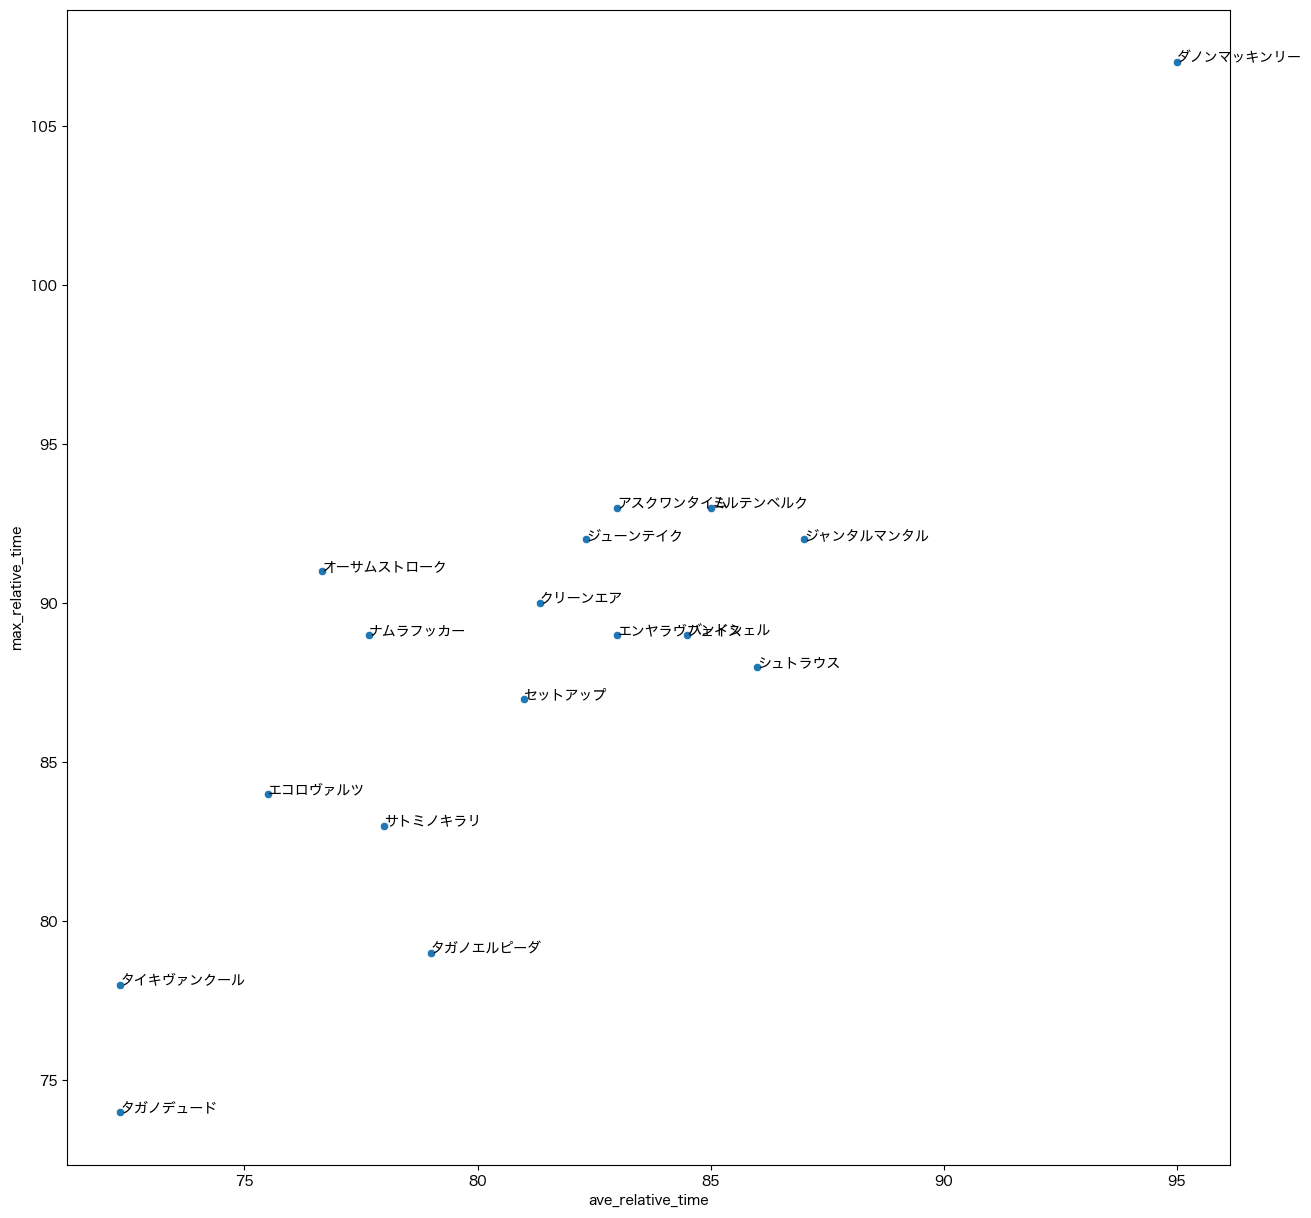

In [16]:
lp.relative_time_plot(pdf)